# SaVi Chatbot

## Install Library

In [ ]:
!cat /proc/cpuinfo | grep "model name" | head -1
!nvidia-smi -L

model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
GPU 0: Tesla T4 (UUID: GPU-c787ad13-bee1-9d98-24ae-ebde373a2cf5)


In [ ]:
'''import tensorflow as tf
if tf.test.is_gpu_available():
    print("TensorFlow menggunakan GPU.")
else:
    print("TensorFlow tidak menggunakan GPU.")'''


'import tensorflow as tf\nif tf.test.is_gpu_available():\n    print("TensorFlow menggunakan GPU.")\nelse:\n    print("TensorFlow tidak menggunakan GPU.")'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install swifter
!pip install transformers
!pip install nlp-id

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16505 sha256=e037dd4bbfb5ab76258734d4a2ddc1f4ec5f661e9c3339e2fd0718dccc219abd
  Stored in directory: /root/.cache/pip/wheels/e4/cf/51/0904952972ee2c7aa3709437065278dc534ec1b8d2ad41b443
Successfully built swifter
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 MB 12.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.5/320.5 kB 30.1 MB/s eta 0:00:00
  Created wheel for nlp-id: filename=nlp_id-0.1.15.0-py3-none-any.whl size=58153891 sha256=4f66199da63850d8138cb306f3b39524a75fa5872f7cf8c2b720c15f55376474
  Stored in directory: /root/.cache/pip/wheels/85/34/2a/deaf7b7896a1eed336b874e1a7732588d40bb7bdc0a824e73e
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=43724063

In [ ]:
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import json
import nltk
import time
import re
import swifter
import seaborn as sns

from nlp_id.lemmatizer import Lemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import transformers
from transformers import BertTokenizer
from transformers import TFBertForSequenceClassification


#from keras.utils.vis_utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import TensorBoard

import sys

import warnings
warnings.filterwarnings("ignore")


# Package sentence tokenizer
nltk.download('punkt')
# Package lemmatization
nltk.download('wordnet')
# Package multilingual wordnet data
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Data Acquisition

In [ ]:
# Importing the dataset
with open('/content/drive/MyDrive/SAVI File/Dataset/Data_Wahana.json') as content:
  data1 = json.load(content)

# Mendapatkan semua data ke dalam list
tags = [] # data tag
inputs = [] # data input atau pattern
responses = {} # data respon
words = [] # Data kata
classes = [] # Data Kelas atau Tag
documents = [] # Data Kalimat Dokumen
ignore_words = ['?', '!'] # Mengabaikan tanda spesial karakter

for intent in data1['intents']:
  responses[intent['tag']]=intent['responses']
  for lines in intent['patterns']:
    inputs.append(lines)
    tags.append(intent['tag'])
    for pattern in intent['patterns']:
      w = nltk.word_tokenize(pattern)
      words.extend(w)
      documents.append((w, intent['tag']))
      # add to our classes list
      if intent['tag'] not in classes:
        classes.append(intent['tag'])

# Konversi data json ke dalam dataframe
data = pd.DataFrame({"patterns":inputs, "tags":tags})

In [ ]:
'''# Cetak data keseluruhan
pd.set_option('display.max_rows', None)
data'''

"# Cetak data keseluruhan\npd.set_option('display.max_rows', None)\ndata"

## Data Visualization

In [ ]:
data.tags.value_counts()

AttributeError: ignored

In [ ]:
# sort classes
classess = sorted(list(set(classes)))
print (len(classess), "classes", classess)

43 classes ['Asal', 'Bantu', 'Baterai', 'Beban', 'Benar', 'Berpisah', 'Buruk', 'Hari', 'Hidup', 'Hobby', 'Hump', 'Identitas', 'InfoBerat', 'Infospeed', 'Jam', 'Kanan', 'Kiri', 'Lebihbaik', 'Lokasi', 'Lucu', 'Maju', 'Malam', 'Mati', 'Mundur', 'Ngobrol', 'Okay', 'Pagi', 'Pembuat', 'Photo', 'Putar', 'Sapa', 'Siang', 'Siap', 'Sore', 'Speed', 'Stop', 'Suhu', 'Tanggal', 'Tanya', 'Terimakasih', 'Usia', 'fitur', 'kabar']


In [ ]:
plt.figure(figsize=(30,20))
red_grad = ['#FF0000', '#BF0000', '#800000', '#400000', '#000000']
black_grad = ['#100C07', '#3E3B39', '#6D6A6A', '#9B9A9C', '#CAC9CD']

order=data['tags'].value_counts().index
y=range(22)


plt.title('Label SAVIBot', fontweight='bold', fontsize=30, fontfamily='sans-serif' )
ax = sns.countplot(x='tags', data=data, color=red_grad[0], edgecolor=red_grad[0])
for rect in ax.patches:
    ax.text (rect.get_x()+rect.get_width()/2,
             rect.get_height()+0.5,int(rect.get_height()),
             horizontalalignment='center', fontsize=20,
             bbox=dict(facecolor='none', edgecolor=black_grad[0],
                       linewidth=0.25, boxstyle='round'))

ax.set_yticks(y)
sns.set(font_scale=1.8)
plt.xticks(rotation=45)
plt.xlabel('Label', fontweight='bold', fontsize=30, fontfamily='sans-serif', labelpad=10)
plt.ylabel('Jumlah Kalimat', fontweight='bold', fontsize=30, fontfamily='sans-serif', labelpad=10)

KeyError: ignored

<Figure size 3000x2000 with 0 Axes>

## Preprocessing

In [ ]:
key_norm = pd.read_csv('/content/drive/MyDrive/SAVI File/Dataset/key_norm_v2.csv')
lemmatizer= Lemmatizer()
#stopwords_ind = stopwords.words('indonesian')
more_stopword = ['savi']
#stopwords_ind = stopwords_ind + more_stopword

In [ ]:
def casefolding(text):
  text = text.lower()                               # Mengubah teks menjadi lower case
  text = re.sub(r'https?://\S+|www\.\S+', '', text) # Menghapus URL
  text = re.sub(r'[-+]?[0-9]+', '', text)           # Menghapus angka
  text = re.sub(r'[^\w\s]','', text)                # Menghapus karakter tanda baca
  text = text.strip()
  return text

# Fungsi untuk Menormalisasi Text
def text_normalize(text):
  text = ' '.join([key_norm[key_norm['singkat'] == word]['hasil'].values[0] if (key_norm['singkat'] == word).any() else word for word in text.split()])
  text = str.lower(text)
  return text

# Buat fungsi untuk langkah stopword removal

def remove_stop_words(text):
  clean_words = []
  text = text.split()
  for word in text:
      if word not in more_stopword:
          clean_words.append(word)
  return ' '.join(clean_words)

def lemma(text):
  text = lemmatizer.lemmatize(text)
  return text

def normalize_repeated_letters(text):
  # Mengganti 3 atau lebih huruf berulang dengan 2 huruf
  text = re.sub(r'(.)\1+', r'\1', text)
  return text

In [ ]:
def text_preprocessing_process(text):
  text = casefolding(text)
  text = text_normalize(text)
  text = lemma(text)
  text = normalize_repeated_letters(text)
  text = remove_stop_words(text)
  return text

In [ ]:
%%time
data['clean patterns'] = data['patterns'].swifter.apply(text_preprocessing_process)

Pandas Apply:   0%|          | 0/383 [00:00<?, ?it/s]

CPU times: user 1.09 s, sys: 24.9 ms, total: 1.12 s
Wall time: 1.18 s


In [ ]:
%%time
data['patterns'] = data['patterns'].swifter.apply(text_preprocessing_process)

Pandas Apply:   0%|          | 0/383 [00:00<?, ?it/s]

CPU times: user 1.7 s, sys: 12.5 ms, total: 1.71 s
Wall time: 1.95 s


In [ ]:
data.sample(n=10)

,patterns,tags,clean patterns
316,"Robot, mundur",Mundur,robot mundur
41,saya mau nanya sama kamu dong,Tanya,saya mau tanya sama kamu dong
215,Berikan lokasi kamu,Lokasi,ikan lokasi kamu
216,Tunjukkan Lokasi mu,Lokasi,tunjuk lokasi mu
213,Robot kamu dimana?,Lokasi,robot kamu mana
318,"Robot, bergeraklah kebelakang",Mundur,robot gerak belakang
345,Lihat ke kiri,Kiri,lihat ke kiri
363,Jumlah beban atau berat yang dapat dibawa,Beban,jumlah beban atau berat yang dapat bawa
343,Belok ke arah kiri,Kiri,belok ke arah kiri
242,Makasih SAVI,Terimakasih,terimakasih


## Encoding Label

In [ ]:
raw_data = data.copy()

In [ ]:
labelencoder = LabelEncoder()
data['tags'] = labelencoder.fit_transform(data['tags'])
data.sample(n=10)

,patterns,tags
95,cipta savibot siapa,27
269,hari ini hari apa,7
122,apakah robot sudah siap,32
111,apakah kamu milik hobi,9
329,diam,35
53,saya punya tanya,38
323,robot henti,35
180,halo siang,31
321,cukup sampai sini,35
288,sped wahana ubah jadi di,34


In [ ]:
data.drop(columns=['clean tags'])

,patterns,tags
0,Siapakah dirimu ini?,Identitas
1,Siapa kamu ini?,Identitas
2,Kamu siapakah?,Identitas
3,Inituh apa?,Identitas
4,Kamu ini apa?,Identitas
...,...,...
378,Barang itu berapa beratnya?,InfoBerat
379,Berapa berat barang yang sedang kamu bawa itu?,InfoBerat
380,Berat yang sedang kau bawa,InfoBerat
381,Berat barang semua adalah,InfoBerat


In [ ]:
labelencoder = LabelEncoder()
data['Encode tags'] = labelencoder.fit_transform(data['tags'])
data.sample(n=10)

,patterns,tags,clean patterns,Encode tags
145,Kamu hebat sekali,Benar,kamu hebat sekali,4
290,Beritahukan aku kecepatanmu sekarang,Infospeed,beritahukan saya cepat sekarang,13
366,Berapa kilo yang sanggup kamu bawa,Beban,berapa kilo yang sangup kamu bawa,3
221,Aku butuh lokasi dari kamu,Lokasi,saya butuh lokasi dari kamu,18
362,Kuat hingga membawa seberapa beban atau berat,Beban,kuat hinga bawa berapa beban atau berat,3
212,Kamu berada dimana?,Lokasi,kamu ada mana,18
329,Diam,Stop,diam,35
121,Apakah kamu siap?,Siap,apakah kamu siap,32
87,kasih tau aku dong kamu diciptakan oleh siapa,Pembuat,kasih tahu saya dong kamu cipta oleh siapa,27
321,Cukup sampai disini,Stop,cukup sampai sini,35


In [ ]:
data_no_duplicates = data.sort_values(by='Encoding tags')
data_no_duplicates

,patterns,tags,Encoding tags
133,robot ini cipta mana,Asal,0
137,kamu buat mana,Asal,0
136,kamu buat dari mana,Asal,0
135,kamu ini berasala dari mana,Asal,0
132,mana kamu cipta,Asal,0
...,...,...,...
369,fitur apa saja yang dapat saya guna di chatbot...,fitur,41
27,apa kabar,kabar,42
28,bagaimana kabar sekarang,kabar,42
29,apakah kamu sehat,kabar,42


## Splitting Data

In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
import pandas as pd

# Misalkan Anda memiliki data dan label_train seperti ini
label_train = data['tags']
data = data.drop(columns=['tags'])

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(data, label_train)

# Gabungkan data dan label_train
resampled_data = pd.DataFrame(X_resampled, columns=data.columns)
resampled_data['tags'] = y_resampled

print(f"Jumlah data sebelum oversampling : {data.shape[0]} data")
print(f"Jumlah data setelah oversampling : {resampled_data.shape[0]} data")

Jumlah data sebelum oversampling : 383 data
Jumlah data setelah oversampling : 903 data


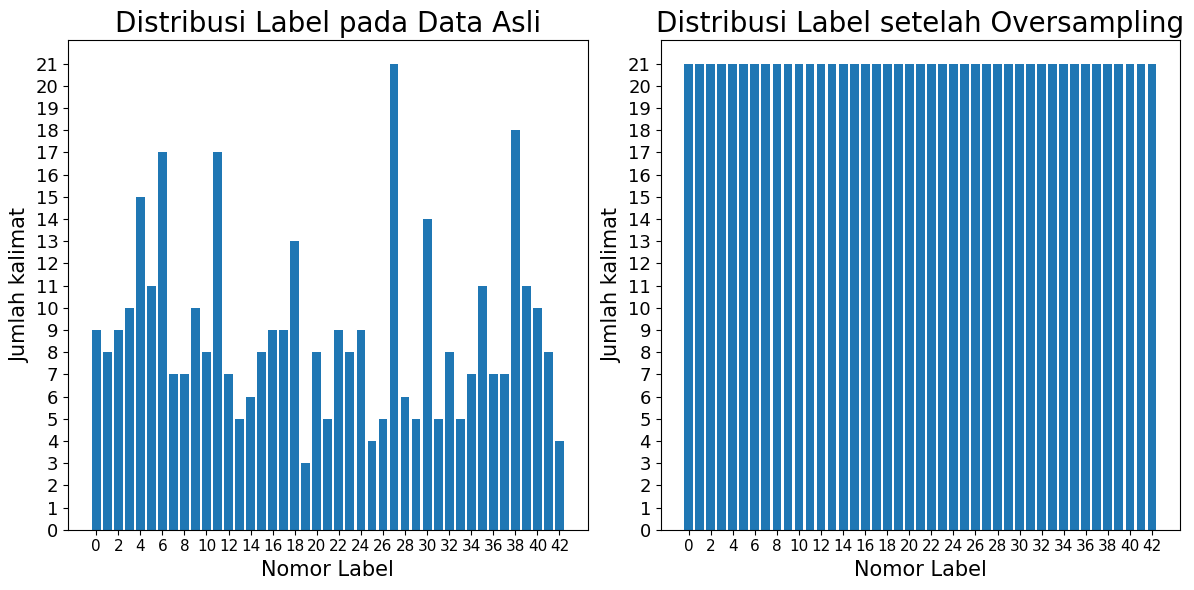

In [ ]:
import matplotlib.pyplot as plt

# Hitung jumlah setiap kelas pada data asli
original_class_counts = label_train.value_counts()
# Hitung jumlah setiap kelas pada data setelah oversampling
resampled_class_counts = resampled_data['tags'].value_counts()

y=range(22)

# Buat dua subplot untuk membandingkan distribusi kelas
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(original_class_counts.index, original_class_counts.values)
plt.title('Distribusi Label pada Data Asli', fontsize = 20)
plt.xlabel('Nomor Label' ,fontsize = 15)
plt.ylabel('Jumlah kalimat', fontsize = 15)
plt.xticks(np.arange(0, 43, 2))
plt.yticks(np.arange(0, 22, 1))
plt.yticks(fontsize=13)
plt.xticks(fontsize=11)

plt.subplot(1, 2, 2)
plt.bar(resampled_class_counts.index, resampled_class_counts.values)
plt.title('Distribusi Label setelah Oversampling',fontsize = 20)
plt.xlabel('Nomor Label',fontsize = 15)
plt.ylabel('Jumlah kalimat',fontsize = 15)
plt.xticks(np.arange(0, 43, 2))
plt.yticks(np.arange(0, 22, 1))
plt.yticks(fontsize=13)
plt.xticks(fontsize=11)

plt.yticks(np.arange(0, 22, 1))
plt.tight_layout()
plt.show()


In [ ]:
data

,patterns
0,siapa diri ini
1,siapa kamu ini
2,kamu siapa
3,inituh apa
4,kamu ini apa
...,...
392,barang itu berapa berat
393,berapa berat barang yang sedang kamu bawa itu
394,berat yang sedang kamu bawa
395,berat barang semua adalah


In [ ]:
df_train, df_val = train_test_split(resampled_data, test_size=0.4, random_state=42)
df_val, df_test = train_test_split(df_val, test_size=0.5, random_state=42)

print(f"Jumlah data training : {df_train.shape[0]} data")
print(f"Jumlah data validasi : {df_val.shape[0]} data")
print(f"Jumlah data test : {df_test.shape[0]} data")

Jumlah data training : 541 data
Jumlah data validasi : 181 data
Jumlah data test : 181 data


In [ ]:
df_train

,patterns,tags
613,hai robot ubah cepat jadi lambat,18
278,tanggal berapa,39
12,savi itu untuk apa,12
182,pagi,28
368,ambil foto atau gambar yang ada depan robot,30
...,...,...
106,saya butuh bantu,1
270,hari apa,8
860,savi henti gerak,37
435,kamu dapat bawa berapa banyak bebanberat,3


In [ ]:
import matplotlib.pyplot as plt

# Hitung jumlah data pada setiap subset
train_count = df_train.shape[0]
val_count = df_val.shape[0]
test_count = df_test.shape[0]

# Buat bar plot untuk memvisualisasikan jumlah data pada setiap subset
plt.figure(figsize=(10, 6))
plt.bar(['Training', 'Validation', 'Test'], [train_count, val_count, test_count], color=['blue', 'green', 'red'])
plt.title('Distribusi Data pada Subset',fontsize = 20)
plt.xlabel('Subset',fontsize = 20)
plt.ylabel('Jumlah Data',fontsize = 20)
plt.yticks(fontsize=13)
plt.xticks(fontsize=15)

# Tambahkan teks dengan jumlah data di atas setiap bar
for i, count in enumerate([train_count, val_count, test_count]):
    plt.text(i, count, str(count), ha='center', va='bottom', fontsize=12)

plt.show()


NameError: ignored

In [ ]:
'''pd.set_option('display.max_rows', None)'''
df_test = df_test.sort_values(by='tags')
df_test

,patterns,tags
382,oke savi,0
365,saya ingin kau mengirimkan barang ini menuju,1
363,apakah kamu dapat mengirimkan barang ini menuj...,1
360,antarkan barang menuju,1
398,berikan barang ini ke tempat,1
...,...,...
223,tengkyu,40
23,diciptakan kapan,41
835,diciptakan kapan,41
836,kapan kamu dibuat,41


In [ ]:
tag_counts = df_val['tags'].value_counts().sort_index(ascending=True)
tag_counts

0     4
1     4
2     4
3     3
4     4
5     8
6     6
7     3
8     2
9     4
10    3
11    5
12    5
13    5
14    6
15    6
16    2
17    3
18    5
19    6
20    3
21    6
22    2
23    3
24    2
25    6
26    3
27    4
28    3
29    4
30    3
31    1
32    4
33    7
34    4
35    3
36    5
37    3
38    4
39    6
40    3
41    1
Name: tags, dtype: int64

## Load Tokenizer IndoBERT

In [ ]:
# Tentukan pre-trained model yang akan digunakan untuk fine-tuning
# Daftar model dapat ditemukan pada https://huggingface.co

PRE_TRAINED_MODEL = 'indobenchmark/indobert-base-p2'  # https://huggingface.co/indobenchmark/indobert-base-p2
bert_tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL)  # Load tokenizer dari pre-trained model
vocabulary = bert_tokenizer.get_vocab()

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

### Kosa kata IndoBERT

#### Contoh Tokenizing Dataset

In [ ]:
import random
print('Panjang vocabulary:', len(vocabulary))
print("Contoh kata dan ID token")
print("---------------------------------")

num_elements = 5
random_keys = random.sample(vocabulary.keys(), num_elements)

# Mencetak elemen-elemen yang dipilih secara acak
for key in random_keys:
    value = vocabulary[key]
    print(f'Kata: {key}, ID Token: {value}')

Panjang vocabulary: 30521
Contoh kata dan ID token
---------------------------------
Kata: vision, ID Token: 26854
Kata: kedepan, ID Token: 9552
Kata: pipinya, ID Token: 26965
Kata: bertakwa, ID Token: 23847
Kata: penuaan, ID Token: 14541


In [ ]:
raw_data

,patterns,tags
0,siapa diri ini,Identitas
1,siapa kamu ini,Identitas
2,kamu siapa,Identitas
3,inituh apa,Identitas
4,kamu ini apa,Identitas
...,...,...
378,barang itu berapa berat,InfoBerat
379,berapa berat barang yang sedang kamu bawa itu,InfoBerat
380,berat yang sedang kamu bawa,InfoBerat
381,berat barang semua adalah,InfoBerat


In [ ]:
# Contoh Tokenisasi
id_data = 221
print('Kalimat:', raw_data.patterns[id_data])
print('BERT Tokenizer:', bert_tokenizer.tokenize(data.patterns[id_data]))

Kalimat: saya butuh lokasi dari kamu
BERT Tokenizer: ['saya', 'butuh', 'lokasi', 'dari', 'kamu']


In [ ]:
# Contoh Tokenisasi
id_data = 302
print('Kalimat:', raw_data.patterns[id_data])
print('BERT Tokenizer:', bert_tokenizer.tokenize(data.patterns[id_data]))

Kalimat: kapasitas baterai kamu sekarang
BERT Tokenizer: ['kapasitas', 'baterai', 'kamu', 'sekarang']


## Menentukan Max Length

Text(0.5, 0, 'Token count')

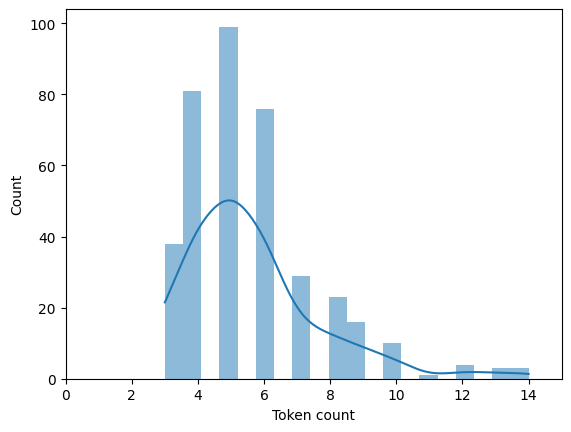

In [ ]:
token_lens = []

for txt in data.patterns:
  tokens = bert_tokenizer.encode(txt)
  token_lens.append(len(tokens))

sns.histplot(token_lens, kde=True, stat='count', linewidth=0)
plt.xlim([0, 15])
plt.xlabel('Token count')

In [ ]:
MAX_LEN = 14

## Input Formatting BERT

### Contoh Input Formatting

In [ ]:
# Contoh input formatting untuk BERT. Input formating dapat menggunakan fungsi `encode_plus`

bert_input = bert_tokenizer.encode_plus(
    data.patterns[id_data],             # Sample kalimat
    add_special_tokens = True,      # Tambahkan token [CLS] pada awal kalimat dan token [SEP] pada akhir kalimat
    padding = 'max_length',         # Tambahkan padding ke max_length menggunakan token [PAD] jika kalimat kurang dari max_length
    truncation = 'longest_first',   # Truncate jika kalimat lebih dari max_length
    max_length = MAX_LEN,                # Tentukan max_length dari seluruh kalimat
    return_attention_mask = True,   # Mengembalikan nilai attention mask
    return_token_type_ids =True,  # Mengembalikan nilai token type id (segment embedding)

    )

# Fungsi `encode_plus` mengembalikan 3 nilai: input_ids, token_type_ids, attention_mask
bert_input.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:

print('Kalimat\t\t:', raw_data.patterns[id_data])                                           # Data asli
print('Tokenizer\t:', bert_tokenizer.convert_ids_to_tokens(bert_input['input_ids']))    # Hasil input formatting + tokenizer
print('Input IDs\t:', bert_input['input_ids'])                                          # Input IDs : indeks token pada vocabulary tokenizer
print('Token Type IDs\t:', bert_input['token_type_ids'])                                # Token type IDs : menunjukkan urutan kalimat pada sequence (segment embedding)
print('Attention Mask\t:', bert_input['attention_mask'])                                # Attention mask : mengembalikan nilai [0,1]. 1 artinya token yang di masking, 0 token yang tidak di masking (diabaikan)



Kalimat		: kapasitas baterai kamu sekarang
Tokenizer	: ['[CLS]', 'kapasitas', 'baterai', 'kamu', 'sekarang', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
Input IDs	: [2, 3707, 5691, 508, 747, 3, 0, 0, 0, 0, 0, 0, 0, 0]
Token Type IDs	: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Attention Mask	: [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]


### Fungsi Formatting

In [ ]:
def convert_example_to_feature(sentence):
  return bert_tokenizer.encode_plus(
      sentence,
      add_special_tokens = True,
      padding = 'max_length',
      truncation = 'longest_first',
      max_length = MAX_LEN,
      return_attention_mask = True,
      return_token_type_ids=True
    )

def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
  return {
      "input_ids": input_ids,               # Sebagai token embedding
      "token_type_ids": token_type_ids,     # Sebagai segment embedding
      "attention_mask": attention_masks,    # Sebagai filter informasi mana yang kalkulasi oleh model
  }, label

# Buat fungsi untuk iterasi pada setiap kalimat pada keseluruhan data
def encode(data):
  input_ids_list = []
  token_type_ids_list = []
  attention_mask_list = []
  label_list = []

  for sentence, label in data.to_numpy():

    bert_input = convert_example_to_feature(sentence)

    input_ids_list.append(bert_input['input_ids'])
    token_type_ids_list.append(bert_input['token_type_ids'])
    attention_mask_list.append(bert_input['attention_mask'])
    label_list.append([label])

  return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(map_example_to_dict)

## Hyperparameter

In [ ]:
BATCH_SIZE_16 = 16
BATCH_SIZE_32 = 16

LEARNING_RATE_5E = 5e-5
LEARNING_RATE_3E = 3e-5
LEARNING_RATE_2E = 2e-5

EPOCHS_10 = 10
EPOCHS_30 = 30
EPOCHS_50 = 50

## Encode Input formatting dengan dataset

In [ ]:
# Lakukan input formatting menggunakan fungsi sebelumnya pada data keseluruhan data
train_encoded_16 = encode(df_train).batch(BATCH_SIZE_16)
test_encoded_16 = encode(df_test).batch(BATCH_SIZE_16)
val_encoded_16 = encode(df_val).batch(BATCH_SIZE_16)

train_encoded_32 = encode(df_train).batch(BATCH_SIZE_32)
test_encoded_32 = encode(df_test).batch(BATCH_SIZE_32)
val_encoded_32 = encode(df_val).batch(BATCH_SIZE_32)

## Pre-trained Modelling IndoBERT

### BS = 16, LR = 5E

In [ ]:
PRE_TRAINED_MODEL = 'indobenchmark/indobert-base-p2'

#### Epoch = 10

In [ ]:
bert_model = TFBertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL, num_labels=43)
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_5E)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
bert_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
%%time
# Compile model
Bert_16_5e_10 = bert_model.fit(train_encoded_16, epochs=EPOCHS_10, batch_size=BATCH_SIZE_16, validation_data=val_encoded_16)

Epoch 1/10
34/34 [==============================] - 60s 290ms/step - loss: 2.8942 - accuracy: 0.4455 - val_loss: 1.7985 - val_accuracy: 0.7845
Epoch 2/10
34/34 [==============================] - 4s 126ms/step - loss: 1.1330 - accuracy: 0.9205 - val_loss: 0.7234 - val_accuracy: 0.9503
Epoch 3/10
34/34 [==============================] - 4s 110ms/step - loss: 0.4186 - accuracy: 0.9908 - val_loss: 0.3451 - val_accuracy: 0.9724
Epoch 4/10
34/34 [==============================] - 4s 109ms/step - loss: 0.2103 - accuracy: 0.9982 - val_loss: 0.2312 - val_accuracy: 0.9834
Epoch 5/10
34/34 [==============================] - 4s 132ms/step - loss: 0.1335 - accuracy: 0.9982 - val_loss: 0.1996 - val_accuracy: 0.9724
Epoch 6/10
34/34 [==============================] - 4s 114ms/step - loss: 0.0965 - accuracy: 0.9982 - val_loss: 0.1489 - val_accuracy: 0.9834
Epoch 7/10
34/34 [==============================] - 4s 114ms/step - loss: 0.0802 - accuracy: 0.9982 - val_loss: 0.1324 - val_accuracy: 0.9834
Epoch

In [ ]:
# Buat fungsi untuk plotting hasil training
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

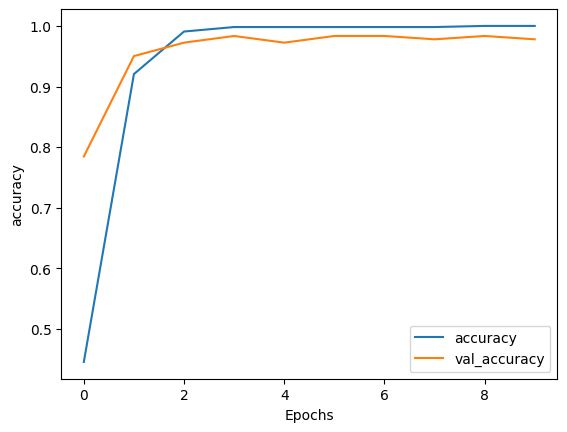

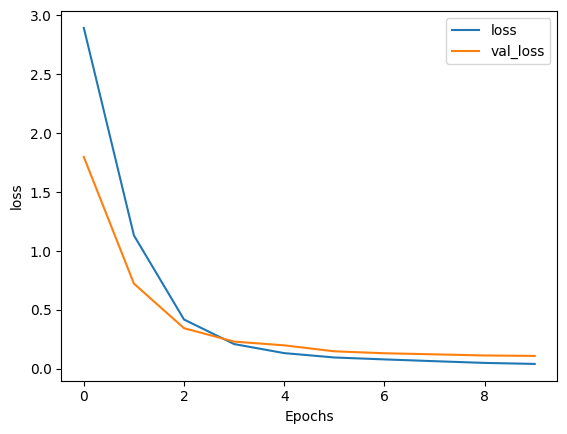

In [ ]:
plot_graphs(Bert_16_5e_10, 'accuracy')
plot_graphs(Bert_16_5e_10, 'loss')

In [ ]:
score = bert_model.evaluate(test_encoded_16)

print("Test Accuracy:", score[1])
print("Test Loss:", score[0])

12/12 [==============================] - 1s 43ms/step - loss: 0.0879 - accuracy: 0.9779
Test Accuracy: 0.9779005646705627
Test Loss: 0.08788134902715683


In [ ]:
bert_model.save_weights(f'/content/drive/MyDrive/SAVI File/New Model/Bert_16_5e_10.h5')

#### Epoch = 30

In [ ]:
bert_model = TFBertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL, num_labels=43)
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_5E)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
bert_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
%%time
# Compile model
Bert_16_5e_30 = bert_model.fit(train_encoded_16, epochs=EPOCHS_30, batch_size=BATCH_SIZE_16, validation_data=val_encoded_16)

Epoch 1/30
34/34 [==============================] - 63s 226ms/step - loss: 3.0066 - accuracy: 0.4214 - val_loss: 1.9236 - val_accuracy: 0.8122
Epoch 2/30
34/34 [==============================] - 4s 119ms/step - loss: 1.2319 - accuracy: 0.9335 - val_loss: 0.7461 - val_accuracy: 0.9558
Epoch 3/30
34/34 [==============================] - 4s 126ms/step - loss: 0.4540 - accuracy: 0.9871 - val_loss: 0.3361 - val_accuracy: 0.9724
Epoch 4/30
34/34 [==============================] - 4s 112ms/step - loss: 0.2272 - accuracy: 0.9908 - val_loss: 0.2295 - val_accuracy: 0.9779
Epoch 5/30
34/34 [==============================] - 4s 114ms/step - loss: 0.1458 - accuracy: 0.9963 - val_loss: 0.1963 - val_accuracy: 0.9724
Epoch 6/30
34/34 [==============================] - 4s 131ms/step - loss: 0.1102 - accuracy: 0.9963 - val_loss: 0.1439 - val_accuracy: 0.9834
Epoch 7/30
34/34 [==============================] - 4s 115ms/step - loss: 0.0795 - accuracy: 1.0000 - val_loss: 0.1225 - val_accuracy: 0.9834
Epoch

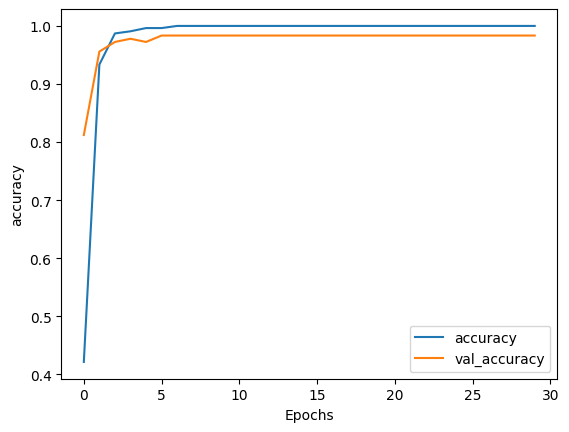

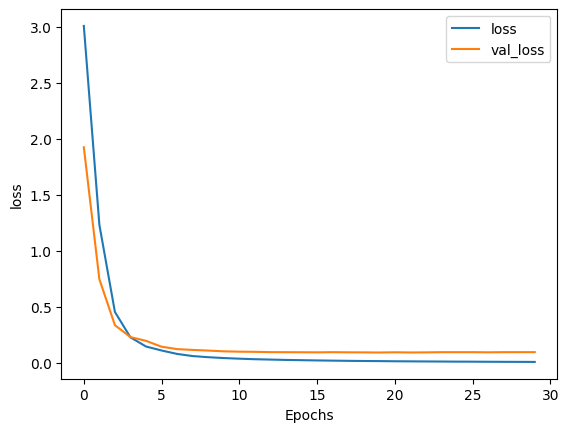

In [ ]:
# Buat fungsi untuk plotting hasil training
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(Bert_16_5e_30, 'accuracy')
plot_graphs(Bert_16_5e_30, 'loss')

In [ ]:
score = bert_model.evaluate(test_encoded_16)

print("Test Accuracy:", score[1])
print("Test Loss:", score[0])

12/12 [==============================] - 1s 46ms/step - loss: 0.0502 - accuracy: 0.9945
Test Accuracy: 0.9944751262664795
Test Loss: 0.05021264776587486


In [ ]:
bert_model.save_weights(f'/content/drive/MyDrive/SAVI File/New Model/Bert_16_5e_30.h5')

#### Epoch = 50

In [ ]:
bert_model = TFBertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL, num_labels=43)
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_5E)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
bert_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
%%time
Bert_16_5e_50 = bert_model.fit(train_encoded_16, epochs=EPOCHS_50, batch_size=BATCH_SIZE_16, validation_data=val_encoded_16)

Epoch 1/50
34/34 [==============================] - 56s 287ms/step - loss: 2.9722 - accuracy: 0.4473 - val_loss: 1.8561 - val_accuracy: 0.8177
Epoch 2/50
34/34 [==============================] - 4s 113ms/step - loss: 1.1917 - accuracy: 0.9464 - val_loss: 0.7258 - val_accuracy: 0.9392
Epoch 3/50
34/34 [==============================] - 4s 116ms/step - loss: 0.4417 - accuracy: 0.9908 - val_loss: 0.3469 - val_accuracy: 0.9779
Epoch 4/50
34/34 [==============================] - 4s 125ms/step - loss: 0.2204 - accuracy: 0.9945 - val_loss: 0.2725 - val_accuracy: 0.9669
Epoch 5/50
34/34 [==============================] - 5s 137ms/step - loss: 0.1372 - accuracy: 0.9982 - val_loss: 0.1852 - val_accuracy: 0.9890
Epoch 6/50
34/34 [==============================] - 4s 113ms/step - loss: 0.1035 - accuracy: 0.9963 - val_loss: 0.1566 - val_accuracy: 0.9779
Epoch 7/50
34/34 [==============================] - 4s 115ms/step - loss: 0.0743 - accuracy: 1.0000 - val_loss: 0.1360 - val_accuracy: 0.9779
Epoch

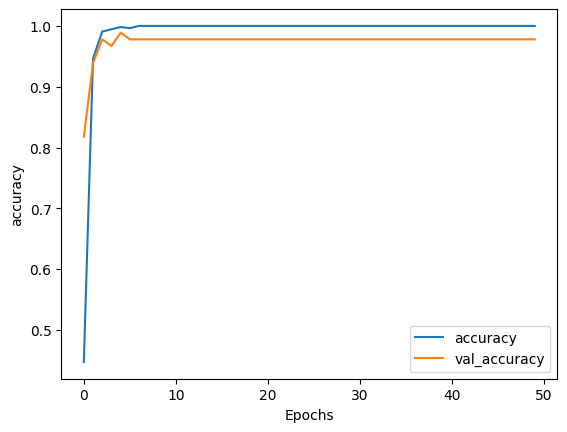

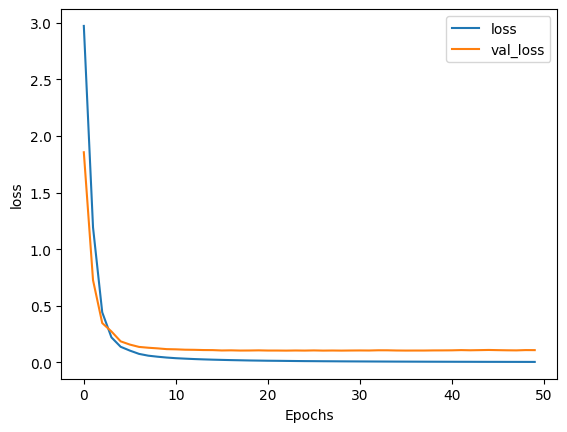

In [ ]:
# Buat fungsi untuk plotting hasil training
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(Bert_16_5e_50, 'accuracy')
plot_graphs(Bert_16_5e_50, 'loss')

In [ ]:
score = bert_model.evaluate(test_encoded_16)

print("Test Accuracy:", score[1])
print("Test Loss:", score[0])

12/12 [==============================] - 0s 34ms/step - loss: 0.0959 - accuracy: 0.9724
Test Accuracy: 0.9723756909370422
Test Loss: 0.0958823710680008


In [ ]:
bert_model.save_weights('/content/drive/MyDrive/SAVI File/New Model/Bert_16_5e_50.h5')

### BS = 16, LR = 3E

#### Epoch = 10

In [ ]:
bert_model = TFBertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL, num_labels=43)
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_3E)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
bert_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
%%time
# Compile model
Bert_16_3e_10 = bert_model.fit(train_encoded_16, epochs=EPOCHS_10, batch_size=BATCH_SIZE_16, validation_data=val_encoded_16)

Epoch 1/10
34/34 [==============================] - 106s 514ms/step - loss: 3.1641 - accuracy: 0.4140 - val_loss: 2.3051 - val_accuracy: 0.8177
Epoch 2/10
34/34 [==============================] - 4s 105ms/step - loss: 1.6344 - accuracy: 0.9187 - val_loss: 1.1291 - val_accuracy: 0.9337
Epoch 3/10
34/34 [==============================] - 4s 116ms/step - loss: 0.7829 - accuracy: 0.9871 - val_loss: 0.6079 - val_accuracy: 0.9613
Epoch 4/10
34/34 [==============================] - 5s 141ms/step - loss: 0.4160 - accuracy: 0.9945 - val_loss: 0.3762 - val_accuracy: 0.9779
Epoch 5/10
34/34 [==============================] - 4s 125ms/step - loss: 0.2643 - accuracy: 0.9963 - val_loss: 0.2811 - val_accuracy: 0.9724
Epoch 6/10
34/34 [==============================] - 4s 106ms/step - loss: 0.1855 - accuracy: 0.9982 - val_loss: 0.2279 - val_accuracy: 0.9779
Epoch 7/10
34/34 [==============================] - 4s 112ms/step - loss: 0.1462 - accuracy: 0.9963 - val_loss: 0.1988 - val_accuracy: 0.9724
Epoc

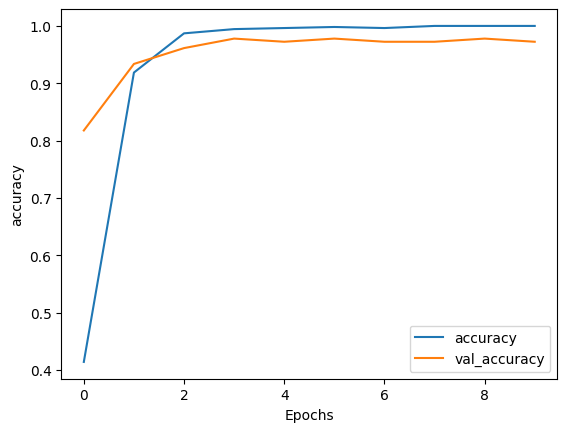

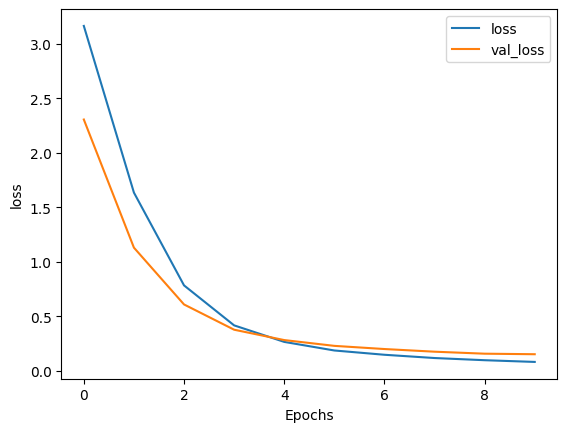

In [ ]:
# Buat fungsi untuk plotting hasil training
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(Bert_16_3e_10, 'accuracy')
plot_graphs(Bert_16_3e_10, 'loss')

In [ ]:
score = bert_model.evaluate(test_encoded_16)

print("Test Accuracy:", score[1])
print("Test Loss:", score[0])

12/12 [==============================] - 0s 34ms/step - loss: 0.1326 - accuracy: 0.9724
Test Accuracy: 0.9723756909370422
Test Loss: 0.13259470462799072


In [ ]:
bert_model.save_weights(f'/content/drive/MyDrive/SAVI File/New Model/Bert_16_3e_10.h5')

#### Epoch = 30

In [ ]:
bert_model = TFBertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL, num_labels=43)
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_3E)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
bert_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
%%time
# Compile model
Bert_16_3e_30 = bert_model.fit(train_encoded_16, epochs=EPOCHS_30, batch_size=BATCH_SIZE_16, validation_data=val_encoded_16)

Epoch 1/30
34/34 [==============================] - 58s 297ms/step - loss: 3.2137 - accuracy: 0.3179 - val_loss: 2.3805 - val_accuracy: 0.7680
Epoch 2/30
34/34 [==============================] - 4s 106ms/step - loss: 1.7502 - accuracy: 0.9076 - val_loss: 1.2370 - val_accuracy: 0.9116
Epoch 3/30
34/34 [==============================] - 4s 113ms/step - loss: 0.8722 - accuracy: 0.9797 - val_loss: 0.6606 - val_accuracy: 0.9558
Epoch 4/30
34/34 [==============================] - 5s 139ms/step - loss: 0.4602 - accuracy: 0.9982 - val_loss: 0.4021 - val_accuracy: 0.9724
Epoch 5/30
34/34 [==============================] - 4s 107ms/step - loss: 0.2796 - accuracy: 0.9982 - val_loss: 0.3007 - val_accuracy: 0.9669
Epoch 6/30
34/34 [==============================] - 4s 112ms/step - loss: 0.1965 - accuracy: 1.0000 - val_loss: 0.2414 - val_accuracy: 0.9669
Epoch 7/30
34/34 [==============================] - 4s 125ms/step - loss: 0.1481 - accuracy: 1.0000 - val_loss: 0.2110 - val_accuracy: 0.9669
Epoch

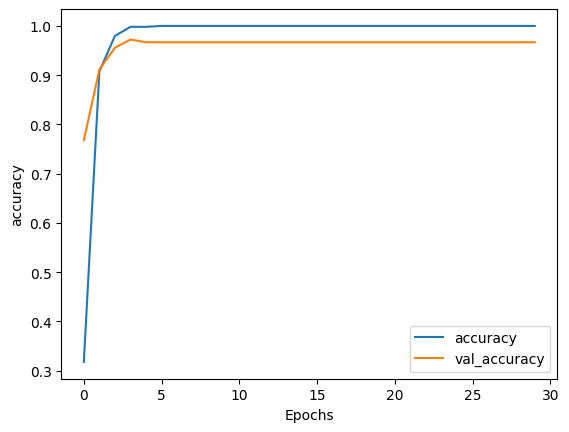

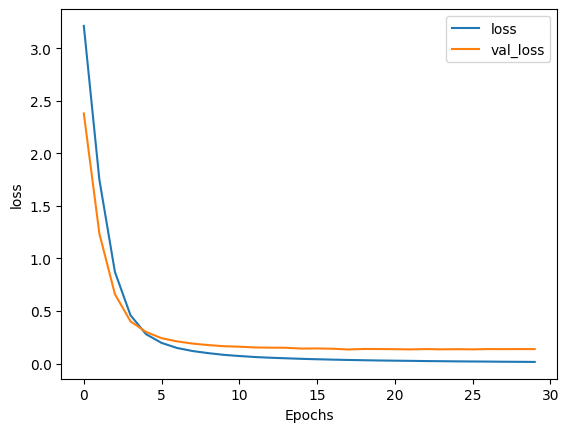

In [ ]:
# Buat fungsi untuk plotting hasil training
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(Bert_16_3e_30, 'accuracy')
plot_graphs(Bert_16_3e_30, 'loss')

In [ ]:
score = bert_model.evaluate(test_encoded_16)

print("Test Accuracy:", score[1])
print("Test Loss:", score[0])

12/12 [==============================] - 0s 32ms/step - loss: 0.0957 - accuracy: 0.9834
Test Accuracy: 0.9834254384040833
Test Loss: 0.09570019692182541


In [ ]:
bert_model.save_weights(f'/content/drive/MyDrive/SAVI File/New Model/Bert_16_3e_30.h5')

#### Epoch = 50

In [ ]:
bert_model = TFBertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL, num_labels=43)
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_3E)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
bert_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
%%time
# Compile model
Bert_16_3e_50 = bert_model.fit(train_encoded_16, epochs=EPOCHS_50, batch_size=BATCH_SIZE_16, validation_data=val_encoded_16)

Epoch 1/50
34/34 [==============================] - 52s 268ms/step - loss: 3.2686 - accuracy: 0.3068 - val_loss: 2.4740 - val_accuracy: 0.7182
Epoch 2/50
34/34 [==============================] - 4s 129ms/step - loss: 1.8131 - accuracy: 0.8872 - val_loss: 1.2977 - val_accuracy: 0.9227
Epoch 3/50
34/34 [==============================] - 4s 123ms/step - loss: 0.8851 - accuracy: 0.9908 - val_loss: 0.6633 - val_accuracy: 0.9724
Epoch 4/50
34/34 [==============================] - 4s 103ms/step - loss: 0.4656 - accuracy: 0.9926 - val_loss: 0.4081 - val_accuracy: 0.9724
Epoch 5/50
34/34 [==============================] - 3s 102ms/step - loss: 0.2862 - accuracy: 0.9982 - val_loss: 0.2858 - val_accuracy: 0.9834
Epoch 6/50
34/34 [==============================] - 4s 121ms/step - loss: 0.2007 - accuracy: 0.9982 - val_loss: 0.2258 - val_accuracy: 0.9890
Epoch 7/50
34/34 [==============================] - 4s 127ms/step - loss: 0.1511 - accuracy: 1.0000 - val_loss: 0.1871 - val_accuracy: 0.9834
Epoch

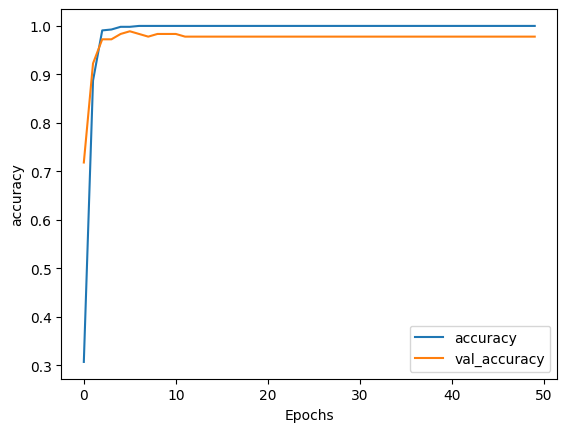

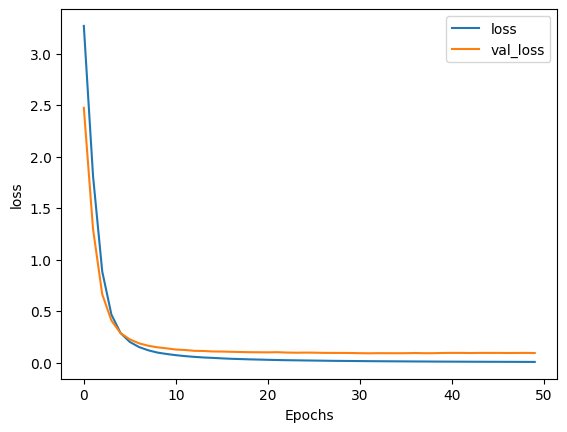

In [ ]:
# Buat fungsi untuk plotting hasil training
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(Bert_16_3e_50, 'accuracy')
plot_graphs(Bert_16_3e_50, 'loss')

In [ ]:
score = bert_model.evaluate(test_encoded_16)

print("Test Accuracy:", score[1])
print("Test Loss:", score[0])

12/12 [==============================] - 1s 41ms/step - loss: 0.0632 - accuracy: 0.9724
Test Accuracy: 0.9723756909370422
Test Loss: 0.06315546482801437


In [ ]:
bert_model.save_weights(f'/content/drive/MyDrive/SAVI File/New Model/Bert_16_3e_50.h5')

### BS = 16, LR = 2E

#### Epoch = 10

In [ ]:
bert_model = TFBertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL, num_labels=43)
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_2E)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
bert_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
%%time
# Compile model
Bert_16_2e_10 = bert_model.fit(train_encoded_16, epochs=EPOCHS_10, batch_size=BATCH_SIZE_16, validation_data=val_encoded_16)

Epoch 1/10
34/34 [==============================] - 57s 357ms/step - loss: 3.3327 - accuracy: 0.2847 - val_loss: 2.6700 - val_accuracy: 0.6409
Epoch 2/10
34/34 [==============================] - 4s 113ms/step - loss: 2.1192 - accuracy: 0.8189 - val_loss: 1.6750 - val_accuracy: 0.8785
Epoch 3/10
34/34 [==============================] - 5s 136ms/step - loss: 1.2781 - accuracy: 0.9593 - val_loss: 1.0406 - val_accuracy: 0.9337
Epoch 4/10
34/34 [==============================] - 4s 113ms/step - loss: 0.7741 - accuracy: 0.9908 - val_loss: 0.6750 - val_accuracy: 0.9558
Epoch 5/10
34/34 [==============================] - 3s 103ms/step - loss: 0.4997 - accuracy: 0.9982 - val_loss: 0.4676 - val_accuracy: 0.9779
Epoch 6/10
34/34 [==============================] - 4s 130ms/step - loss: 0.3427 - accuracy: 0.9982 - val_loss: 0.3485 - val_accuracy: 0.9779
Epoch 7/10
34/34 [==============================] - 6s 175ms/step - loss: 0.2583 - accuracy: 1.0000 - val_loss: 0.2793 - val_accuracy: 0.9779
Epoch

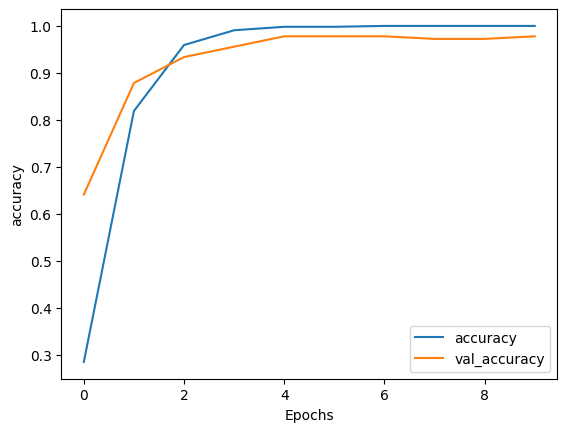

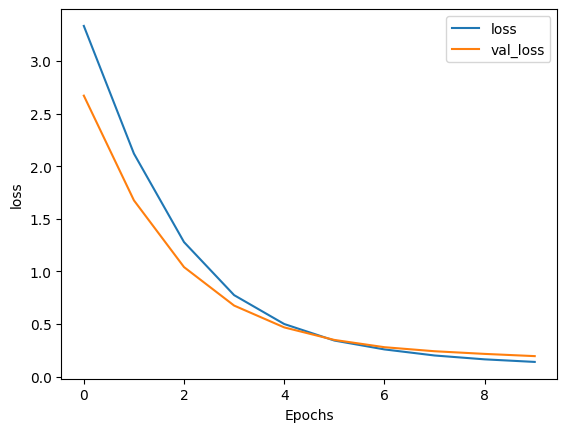

In [ ]:
# Buat fungsi untuk plotting hasil training
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(Bert_16_2e_10, 'accuracy')
plot_graphs(Bert_16_2e_10, 'loss')

In [ ]:
score = bert_model.evaluate(test_encoded_16)

print("Test Accuracy:", score[1])
print("Test Loss:", score[0])

12/12 [==============================] - 1s 42ms/step - loss: 0.1656 - accuracy: 0.9834
Test Accuracy: 0.9834254384040833
Test Loss: 0.16557881236076355


In [ ]:
bert_model.save_weights(f'/content/drive/MyDrive/SAVI File/New Model/Bert_16_2e_10.h5')

#### Epoch = 30

In [ ]:
bert_model = TFBertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL, num_labels=43)
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_2E)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
bert_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
%%time
# Compile model
Bert_16_2e_30 = bert_model.fit(train_encoded_16, epochs=EPOCHS_30, batch_size=BATCH_SIZE_16, validation_data=val_encoded_16)

Epoch 1/30
34/34 [==============================] - 50s 288ms/step - loss: 3.4242 - accuracy: 0.2736 - val_loss: 2.8145 - val_accuracy: 0.6188
Epoch 2/30
34/34 [==============================] - 4s 105ms/step - loss: 2.2276 - accuracy: 0.8059 - val_loss: 1.7698 - val_accuracy: 0.8895
Epoch 3/30
34/34 [==============================] - 5s 136ms/step - loss: 1.3519 - accuracy: 0.9630 - val_loss: 1.0730 - val_accuracy: 0.9503
Epoch 4/30
34/34 [==============================] - 4s 125ms/step - loss: 0.8260 - accuracy: 0.9889 - val_loss: 0.6933 - val_accuracy: 0.9669
Epoch 5/30
34/34 [==============================] - 3s 102ms/step - loss: 0.5336 - accuracy: 0.9963 - val_loss: 0.4923 - val_accuracy: 0.9669
Epoch 6/30
34/34 [==============================] - 4s 112ms/step - loss: 0.3713 - accuracy: 1.0000 - val_loss: 0.3818 - val_accuracy: 0.9779
Epoch 7/30
34/34 [==============================] - 5s 133ms/step - loss: 0.2787 - accuracy: 1.0000 - val_loss: 0.2970 - val_accuracy: 0.9779
Epoch

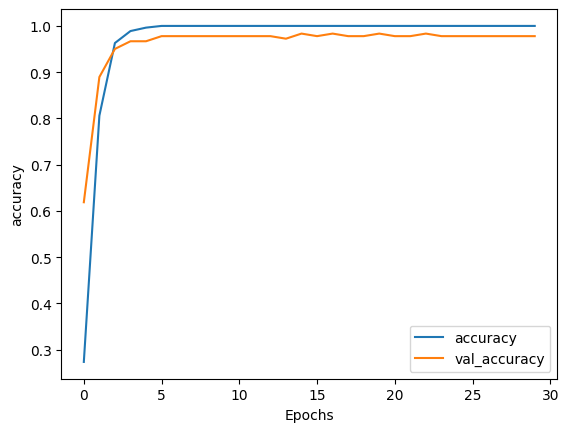

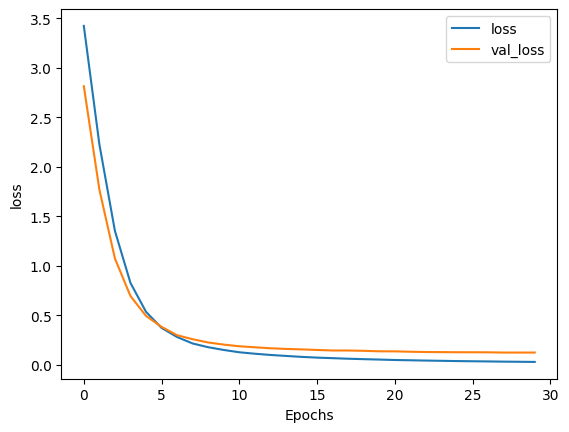

In [ ]:
# Buat fungsi untuk plotting hasil training
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(Bert_16_2e_30, 'accuracy')
plot_graphs(Bert_16_2e_30, 'loss')

In [ ]:
score = bert_model.evaluate(test_encoded_16)

print("Test Accuracy:", score[1])
print("Test Loss:", score[0])

12/12 [==============================] - 0s 32ms/step - loss: 0.1037 - accuracy: 0.9669
Test Accuracy: 0.9668508172035217
Test Loss: 0.1037144660949707


In [ ]:
bert_model.save_weights(f'/content/drive/MyDrive/SAVI File/New Model/Bert_16_2e_30.h5')

#### Epoch = 50

In [ ]:
bert_model = TFBertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL, num_labels=43)
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_2E)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
bert_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
%%time
# Compile model
Bert_16_2e_50 = bert_model.fit(train_encoded_16, epochs=EPOCHS_50, batch_size=BATCH_SIZE_16, validation_data=val_encoded_16)

Epoch 1/50
34/34 [==============================] - 51s 252ms/step - loss: 3.3829 - accuracy: 0.2662 - val_loss: 2.7448 - val_accuracy: 0.6519
Epoch 2/50
34/34 [==============================] - 5s 133ms/step - loss: 2.1510 - accuracy: 0.8780 - val_loss: 1.6817 - val_accuracy: 0.9227
Epoch 3/50
34/34 [==============================] - 4s 125ms/step - loss: 1.2696 - accuracy: 0.9741 - val_loss: 1.0181 - val_accuracy: 0.9503
Epoch 4/50
34/34 [==============================] - 4s 111ms/step - loss: 0.7552 - accuracy: 0.9889 - val_loss: 0.6411 - val_accuracy: 0.9779
Epoch 5/50
34/34 [==============================] - 4s 110ms/step - loss: 0.4878 - accuracy: 0.9963 - val_loss: 0.4447 - val_accuracy: 0.9890
Epoch 6/50
34/34 [==============================] - 5s 135ms/step - loss: 0.3386 - accuracy: 0.9982 - val_loss: 0.3362 - val_accuracy: 0.9834
Epoch 7/50
34/34 [==============================] - 4s 130ms/step - loss: 0.2542 - accuracy: 1.0000 - val_loss: 0.2657 - val_accuracy: 0.9779
Epoch

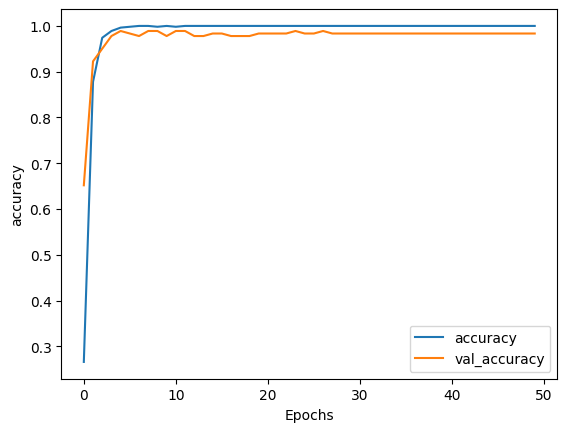

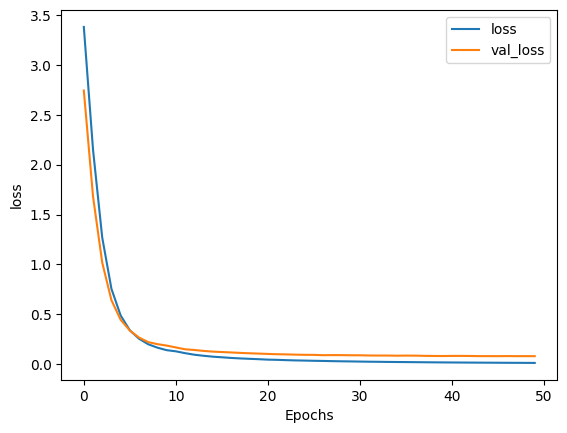

In [ ]:
# Buat fungsi untuk plotting hasil training
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(Bert_16_2e_50, 'accuracy')
plot_graphs(Bert_16_2e_50, 'loss')

In [ ]:
score = bert_model.evaluate(test_encoded_16)

print("Test Accuracy:", score[1])
print("Test Loss:", score[0])

12/12 [==============================] - 1s 54ms/step - loss: 0.0707 - accuracy: 0.9779
Test Accuracy: 0.9779005646705627
Test Loss: 0.07067861407995224


In [ ]:
bert_model.save_weights(f'/content/drive/MyDrive/SAVI File/New Model/Bert_16_2e_50.h5')

### BS = 32, LR = 5E

#### Epoch = 10

In [ ]:
bert_model = TFBertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL, num_labels=43)
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_5E)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
bert_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
%%time
# Compile model
Bert_32_5e_10 = bert_model.fit(train_encoded_32, epochs=EPOCHS_10, batch_size=BATCH_SIZE_32, validation_data=val_encoded_32)

Epoch 1/10
34/34 [==============================] - 52s 229ms/step - loss: 3.0107 - accuracy: 0.4159 - val_loss: 1.9546 - val_accuracy: 0.8453
Epoch 2/10
34/34 [==============================] - 4s 122ms/step - loss: 1.2443 - accuracy: 0.9390 - val_loss: 0.7494 - val_accuracy: 0.9613
Epoch 3/10
34/34 [==============================] - 4s 112ms/step - loss: 0.4583 - accuracy: 0.9926 - val_loss: 0.3980 - val_accuracy: 0.9558
Epoch 4/10
34/34 [==============================] - 4s 105ms/step - loss: 0.2299 - accuracy: 0.9926 - val_loss: 0.2566 - val_accuracy: 0.9724
Epoch 5/10
34/34 [==============================] - 4s 132ms/step - loss: 0.1388 - accuracy: 0.9982 - val_loss: 0.1895 - val_accuracy: 0.9669
Epoch 6/10
34/34 [==============================] - 4s 123ms/step - loss: 0.0966 - accuracy: 1.0000 - val_loss: 0.1633 - val_accuracy: 0.9669
Epoch 7/10
34/34 [==============================] - 4s 112ms/step - loss: 0.0731 - accuracy: 1.0000 - val_loss: 0.1456 - val_accuracy: 0.9669
Epoch

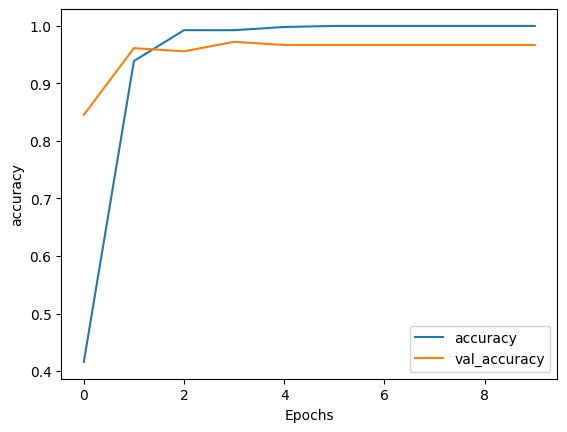

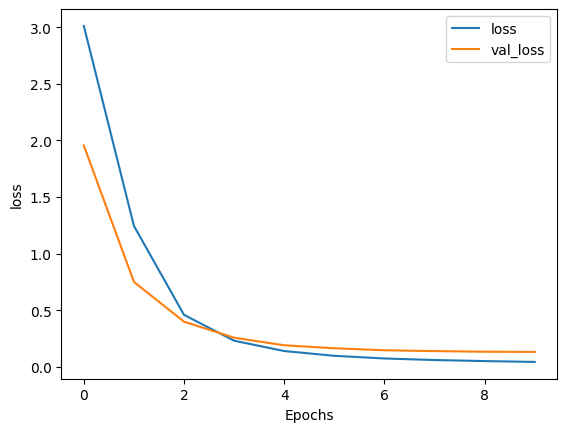

In [ ]:
# Buat fungsi untuk plotting hasil training
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(Bert_32_5e_10, 'accuracy')
plot_graphs(Bert_32_5e_10, 'loss')

In [ ]:
score = bert_model.evaluate(test_encoded_32)

print("Test Accuracy:", score[1])
print("Test Loss:", score[0])

12/12 [==============================] - 0s 36ms/step - loss: 0.0853 - accuracy: 0.9834
Test Accuracy: 0.9834254384040833
Test Loss: 0.08525894582271576


In [ ]:
bert_model.save_weights(f'/content/drive/MyDrive/SAVI File/New Model/Bert_32_5e_10.h5')

#### Epoch = 30

In [ ]:
bert_model = TFBertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL, num_labels=43)
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_5E)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
bert_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
%%time
# Compile model
Bert_32_5e_30 = bert_model.fit(train_encoded_32, epochs=EPOCHS_30, batch_size=BATCH_SIZE_32, validation_data=val_encoded_32)

Epoch 1/30
34/34 [==============================] - 51s 279ms/step - loss: 2.9265 - accuracy: 0.4566 - val_loss: 1.8078 - val_accuracy: 0.8011
Epoch 2/30
34/34 [==============================] - 4s 105ms/step - loss: 1.1343 - accuracy: 0.9316 - val_loss: 0.7095 - val_accuracy: 0.9503
Epoch 3/30
34/34 [==============================] - 4s 129ms/step - loss: 0.4121 - accuracy: 0.9945 - val_loss: 0.3540 - val_accuracy: 0.9669
Epoch 4/30
34/34 [==============================] - 4s 133ms/step - loss: 0.2020 - accuracy: 0.9982 - val_loss: 0.2216 - val_accuracy: 0.9834
Epoch 5/30
34/34 [==============================] - 4s 112ms/step - loss: 0.1258 - accuracy: 1.0000 - val_loss: 0.1805 - val_accuracy: 0.9669
Epoch 6/30
34/34 [==============================] - 4s 103ms/step - loss: 0.0920 - accuracy: 1.0000 - val_loss: 0.1556 - val_accuracy: 0.9779
Epoch 7/30
34/34 [==============================] - 5s 134ms/step - loss: 0.0727 - accuracy: 1.0000 - val_loss: 0.1480 - val_accuracy: 0.9724
Epoch

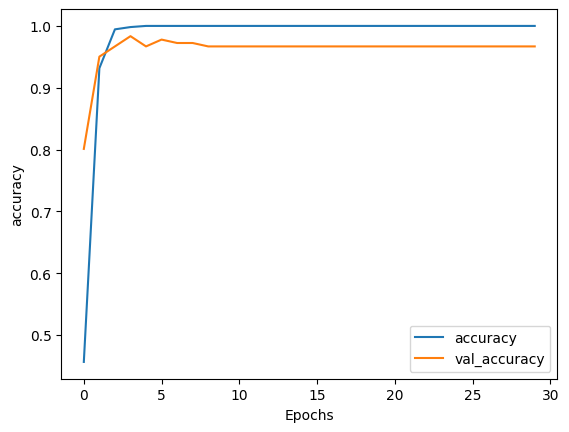

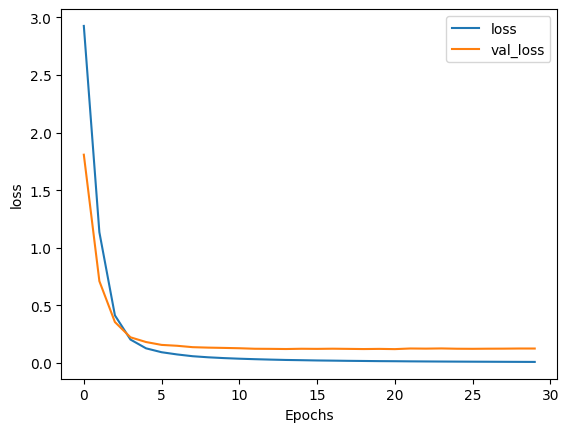

In [ ]:
# Buat fungsi untuk plotting hasil training
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(Bert_32_5e_30, 'accuracy')
plot_graphs(Bert_32_5e_30, 'loss')

In [ ]:
score = bert_model.evaluate(test_encoded_32)

print("Test Accuracy:", score[1])
print("Test Loss:", score[0])

12/12 [==============================] - 1s 51ms/step - loss: 0.0738 - accuracy: 0.9834
Test Accuracy: 0.9834254384040833
Test Loss: 0.07377946376800537


In [ ]:
bert_model.save_weights(f'/content/drive/MyDrive/SAVI File/New Model/Bert_32_5e_30_new.h5')

#### Epoch = 50

In [ ]:
bert_model = TFBertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL, num_labels=43)
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_5E)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
bert_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
%%time
# Compile model
Bert_32_5e_50 = bert_model.fit(train_encoded_32, epochs=EPOCHS_50, batch_size=BATCH_SIZE_32, validation_data=val_encoded_32)

Epoch 1/50
34/34 [==============================] - 57s 281ms/step - loss: 2.8807 - accuracy: 0.4732 - val_loss: 1.8100 - val_accuracy: 0.8453
Epoch 2/50
34/34 [==============================] - 4s 103ms/step - loss: 1.1220 - accuracy: 0.9501 - val_loss: 0.7038 - val_accuracy: 0.9503
Epoch 3/50
34/34 [==============================] - 4s 112ms/step - loss: 0.4119 - accuracy: 0.9963 - val_loss: 0.3310 - val_accuracy: 0.9779
Epoch 4/50
34/34 [==============================] - 5s 143ms/step - loss: 0.2008 - accuracy: 0.9963 - val_loss: 0.2220 - val_accuracy: 0.9724
Epoch 5/50
34/34 [==============================] - 4s 112ms/step - loss: 0.1349 - accuracy: 0.9982 - val_loss: 0.1735 - val_accuracy: 0.9779
Epoch 6/50
34/34 [==============================] - 4s 104ms/step - loss: 0.0947 - accuracy: 1.0000 - val_loss: 0.1469 - val_accuracy: 0.9779
Epoch 7/50
34/34 [==============================] - 4s 117ms/step - loss: 0.0713 - accuracy: 1.0000 - val_loss: 0.1324 - val_accuracy: 0.9779
Epoch

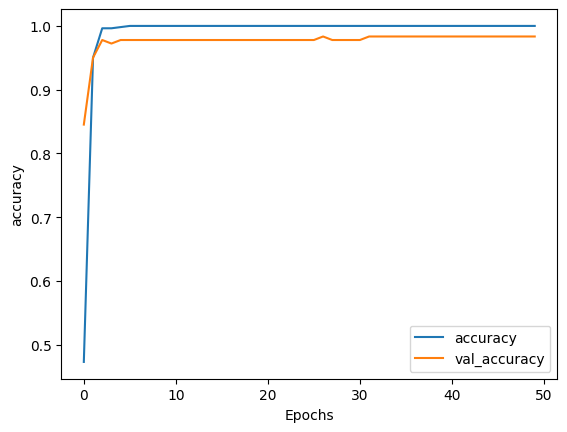

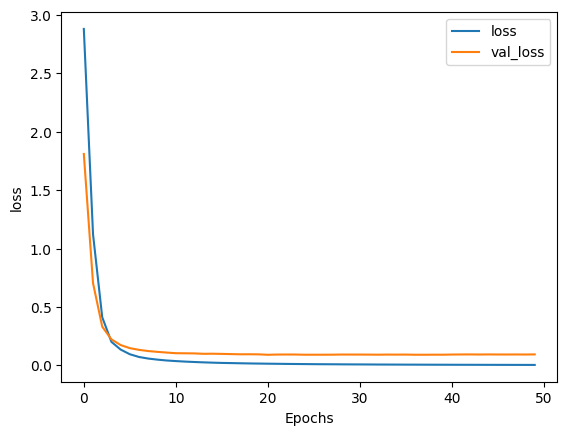

In [ ]:
# Buat fungsi untuk plotting hasil training
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(Bert_32_5e_50, 'accuracy')
plot_graphs(Bert_32_5e_50, 'loss')

In [ ]:
score = bert_model.evaluate(test_encoded_32)

print("Test Accuracy:", score[1])
print("Test Loss:", score[0])

12/12 [==============================] - 1s 47ms/step - loss: 0.0384 - accuracy: 0.9890
Test Accuracy: 0.988950252532959
Test Loss: 0.03838152438402176


In [ ]:
bert_model.save_weights(f'/content/drive/MyDrive/SAVI File/New Model/Bert_32_5e_50.h5')

### BS = 32, LR = 3E

#### Epoch = 10

In [ ]:
bert_model = TFBertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL, num_labels=43)
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_3E)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
bert_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
%%time
# Compile model
Bert_32_3e_10 = bert_model.fit(train_encoded_32, epochs=EPOCHS_10, batch_size=BATCH_SIZE_32, validation_data=val_encoded_32)

Epoch 1/10
34/34 [==============================] - 57s 233ms/step - loss: 3.2218 - accuracy: 0.3475 - val_loss: 2.4503 - val_accuracy: 0.6796
Epoch 2/10
34/34 [==============================] - 5s 135ms/step - loss: 1.7567 - accuracy: 0.8835 - val_loss: 1.2771 - val_accuracy: 0.9448
Epoch 3/10
34/34 [==============================] - 4s 110ms/step - loss: 0.8757 - accuracy: 0.9889 - val_loss: 0.6503 - val_accuracy: 0.9724
Epoch 4/10
34/34 [==============================] - 4s 112ms/step - loss: 0.4507 - accuracy: 0.9963 - val_loss: 0.3995 - val_accuracy: 0.9834
Epoch 5/10
34/34 [==============================] - 4s 122ms/step - loss: 0.2771 - accuracy: 0.9963 - val_loss: 0.2793 - val_accuracy: 0.9834
Epoch 6/10
34/34 [==============================] - 5s 134ms/step - loss: 0.1966 - accuracy: 0.9982 - val_loss: 0.2320 - val_accuracy: 0.9779
Epoch 7/10
34/34 [==============================] - 3s 103ms/step - loss: 0.1475 - accuracy: 1.0000 - val_loss: 0.1946 - val_accuracy: 0.9669
Epoch

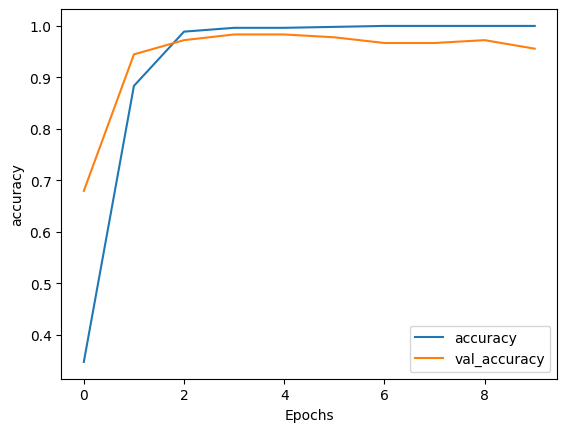

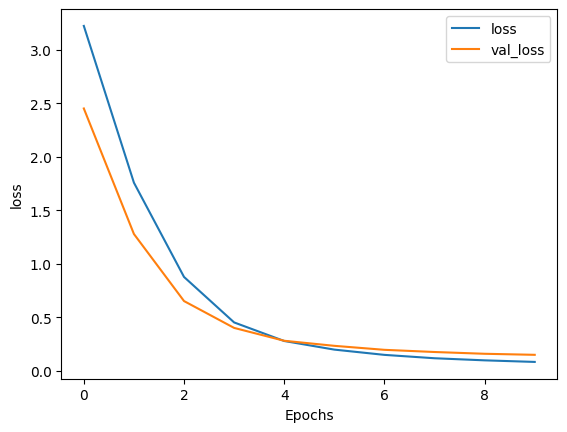

In [ ]:
# Buat fungsi untuk plotting hasil training
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(Bert_32_3e_10, 'accuracy')
plot_graphs(Bert_32_3e_10, 'loss')

In [ ]:
score = bert_model.evaluate(test_encoded_32)

print("Test Accuracy:", score[1])
print("Test Loss:", score[0])

12/12 [==============================] - 0s 34ms/step - loss: 0.1223 - accuracy: 0.9779
Test Accuracy: 0.9779005646705627
Test Loss: 0.12230861186981201


In [ ]:
bert_model.save_weights(f'/content/drive/MyDrive/SAVI File/New Model/Bert_32_3e_10.h5')

#### Epoch = 30

In [ ]:
bert_model = TFBertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL, num_labels=43)
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_3E)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
bert_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
%%time
# Compile model
Bert_32_3e_30 = bert_model.fit(train_encoded_32, epochs=EPOCHS_30, batch_size=BATCH_SIZE_32, validation_data=val_encoded_32)

Epoch 1/30
34/34 [==============================] - 55s 238ms/step - loss: 3.1753 - accuracy: 0.3863 - val_loss: 2.4116 - val_accuracy: 0.7348
Epoch 2/30
34/34 [==============================] - 4s 108ms/step - loss: 1.7498 - accuracy: 0.8835 - val_loss: 1.3053 - val_accuracy: 0.9171
Epoch 3/30
34/34 [==============================] - 5s 141ms/step - loss: 0.8894 - accuracy: 0.9815 - val_loss: 0.6977 - val_accuracy: 0.9558
Epoch 4/30
34/34 [==============================] - 4s 104ms/step - loss: 0.4619 - accuracy: 0.9982 - val_loss: 0.4385 - val_accuracy: 0.9613
Epoch 5/30
34/34 [==============================] - 4s 113ms/step - loss: 0.2841 - accuracy: 0.9982 - val_loss: 0.3197 - val_accuracy: 0.9613
Epoch 6/30
34/34 [==============================] - 4s 127ms/step - loss: 0.1961 - accuracy: 1.0000 - val_loss: 0.2703 - val_accuracy: 0.9613
Epoch 7/30
34/34 [==============================] - 5s 141ms/step - loss: 0.1490 - accuracy: 1.0000 - val_loss: 0.2357 - val_accuracy: 0.9613
Epoch

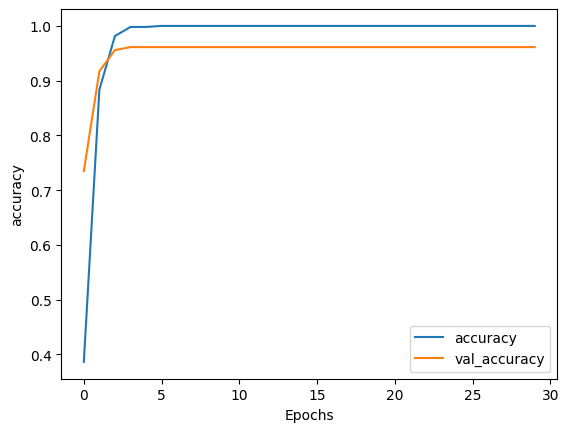

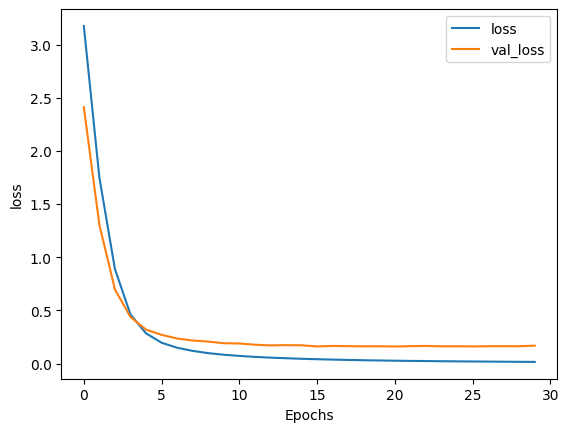

In [ ]:
# Buat fungsi untuk plotting hasil training
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(Bert_32_3e_30, 'accuracy')
plot_graphs(Bert_32_3e_30, 'loss')

In [ ]:
score = bert_model.evaluate(test_encoded_32)

print("Test Accuracy:", score[1])
print("Test Loss:", score[0])

12/12 [==============================] - 0s 35ms/step - loss: 0.1055 - accuracy: 0.9724
Test Accuracy: 0.9723756909370422
Test Loss: 0.10552745312452316


In [ ]:
bert_model.save_weights(f'/content/drive/MyDrive/SAVI File/New Model/Bert_32_3e_30.h5')

#### Epoch = 50

In [ ]:
bert_model = TFBertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL, num_labels=43)
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_3E)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
bert_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
%%time
# Compile model
Bert_32_3e_50 = bert_model.fit(train_encoded_32, epochs=EPOCHS_50, batch_size=BATCH_SIZE_32, validation_data=val_encoded_32)

Epoch 1/50
34/34 [==============================] - 53s 268ms/step - loss: 3.2278 - accuracy: 0.3586 - val_loss: 2.3519 - val_accuracy: 0.8122
Epoch 2/50
34/34 [==============================] - 4s 127ms/step - loss: 1.7319 - accuracy: 0.9279 - val_loss: 1.1846 - val_accuracy: 0.9171
Epoch 3/50
34/34 [==============================] - 4s 105ms/step - loss: 0.8493 - accuracy: 0.9834 - val_loss: 0.6326 - val_accuracy: 0.9669
Epoch 4/50
34/34 [==============================] - 4s 114ms/step - loss: 0.4420 - accuracy: 0.9982 - val_loss: 0.3914 - val_accuracy: 0.9724
Epoch 5/50
34/34 [==============================] - 5s 135ms/step - loss: 0.2694 - accuracy: 1.0000 - val_loss: 0.2799 - val_accuracy: 0.9779
Epoch 6/50
34/34 [==============================] - 5s 135ms/step - loss: 0.1927 - accuracy: 1.0000 - val_loss: 0.2281 - val_accuracy: 0.9779
Epoch 7/50
34/34 [==============================] - 4s 105ms/step - loss: 0.1469 - accuracy: 1.0000 - val_loss: 0.1973 - val_accuracy: 0.9724
Epoch

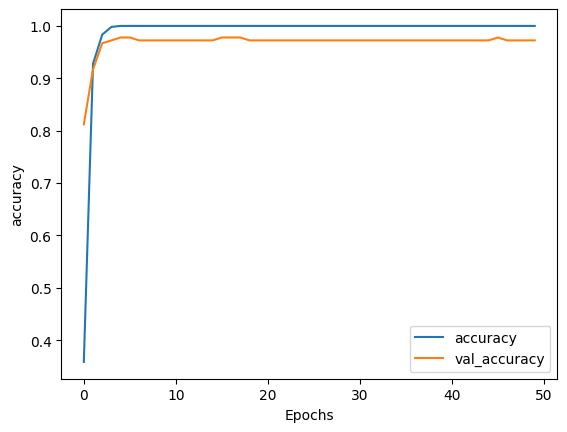

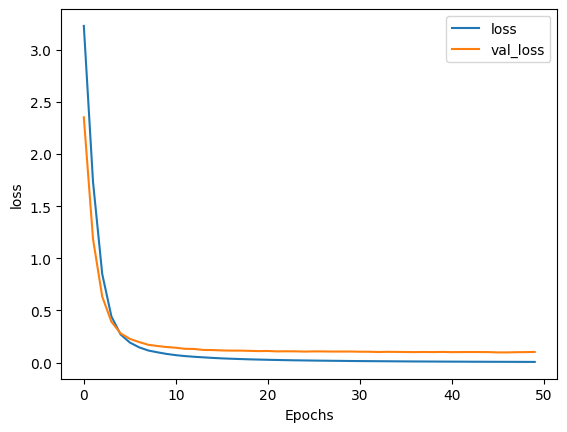

In [ ]:
# Buat fungsi untuk plotting hasil training
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(Bert_32_3e_50, 'accuracy')
plot_graphs(Bert_32_3e_50, 'loss')

In [ ]:
score = bert_model.evaluate(test_encoded_32)

print("Test Accuracy:", score[1])
print("Test Loss:", score[0])

12/12 [==============================] - 0s 37ms/step - loss: 0.0872 - accuracy: 0.9724
Test Accuracy: 0.9723756909370422
Test Loss: 0.08716956526041031


In [ ]:
bert_model.save_weights(f'/content/drive/MyDrive/SAVI File/New Model/Bert_32_3e_50.h5')

### BS = 32, LR = 2E

#### Epoch = 10

In [ ]:
bert_model = TFBertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL, num_labels=43)
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_2E)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
bert_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
%%time
# Compile model
Bert_32_2e_10 = bert_model.fit(train_encoded_32, epochs=EPOCHS_10, batch_size=BATCH_SIZE_32, validation_data=val_encoded_32)

Epoch 1/10
34/34 [==============================] - 54s 232ms/step - loss: 3.4417 - accuracy: 0.2181 - val_loss: 2.8813 - val_accuracy: 0.5525
Epoch 2/10
34/34 [==============================] - 5s 134ms/step - loss: 2.3236 - accuracy: 0.7542 - val_loss: 1.8502 - val_accuracy: 0.8729
Epoch 3/10
34/34 [==============================] - 5s 138ms/step - loss: 1.4228 - accuracy: 0.9445 - val_loss: 1.1242 - val_accuracy: 0.9282
Epoch 4/10
34/34 [==============================] - 4s 106ms/step - loss: 0.8589 - accuracy: 0.9834 - val_loss: 0.7042 - val_accuracy: 0.9669
Epoch 5/10
34/34 [==============================] - 4s 114ms/step - loss: 0.5373 - accuracy: 0.9982 - val_loss: 0.4837 - val_accuracy: 0.9669
Epoch 6/10
34/34 [==============================] - 5s 139ms/step - loss: 0.3602 - accuracy: 1.0000 - val_loss: 0.3555 - val_accuracy: 0.9779
Epoch 7/10
34/34 [==============================] - 4s 132ms/step - loss: 0.2670 - accuracy: 1.0000 - val_loss: 0.2922 - val_accuracy: 0.9669
Epoch

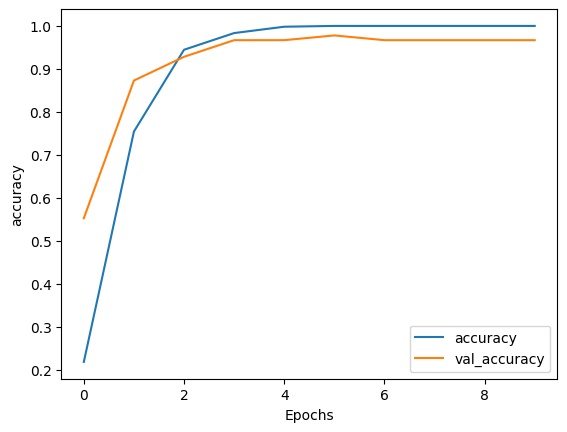

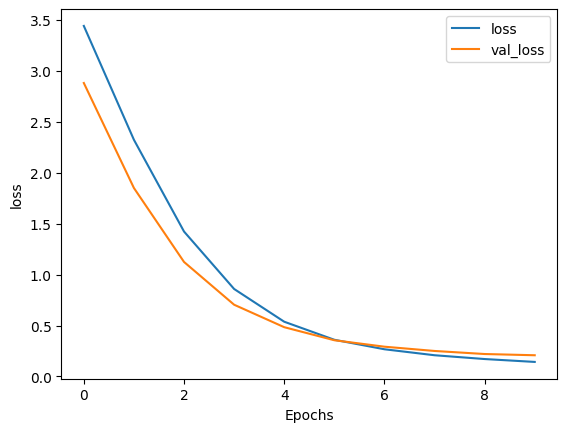

In [ ]:
# Buat fungsi untuk plotting hasil training
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(Bert_32_2e_10, 'accuracy')
plot_graphs(Bert_32_2e_10, 'loss')

In [ ]:
score = bert_model.evaluate(test_encoded_32)

print("Test Accuracy:", score[1])
print("Test Loss:", score[0])

12/12 [==============================] - 1s 68ms/step - loss: 0.1769 - accuracy: 0.9724
Test Accuracy: 0.9723756909370422
Test Loss: 0.17690791189670563


In [ ]:
bert_model.save_weights(f'/content/drive/MyDrive/SAVI File/New Model/Bert_32_2e_10.h5')

#### Epoch = 30

In [ ]:
bert_model = TFBertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL, num_labels=43)
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_2E)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
bert_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
%%time
# Compile model
Bert_32_2e_30 = bert_model.fit(train_encoded_32, epochs=EPOCHS_30, batch_size=BATCH_SIZE_32, validation_data=val_encoded_32)

Epoch 1/30
34/34 [==============================] - 53s 239ms/step - loss: 3.3972 - accuracy: 0.2384 - val_loss: 2.7972 - val_accuracy: 0.5691
Epoch 2/30
34/34 [==============================] - 4s 116ms/step - loss: 2.2220 - accuracy: 0.7948 - val_loss: 1.7965 - val_accuracy: 0.8674
Epoch 3/30
34/34 [==============================] - 5s 136ms/step - loss: 1.3445 - accuracy: 0.9593 - val_loss: 1.0928 - val_accuracy: 0.9337
Epoch 4/30
34/34 [==============================] - 4s 107ms/step - loss: 0.8088 - accuracy: 0.9889 - val_loss: 0.6918 - val_accuracy: 0.9669
Epoch 5/30
34/34 [==============================] - 4s 127ms/step - loss: 0.5152 - accuracy: 0.9945 - val_loss: 0.4806 - val_accuracy: 0.9669
Epoch 6/30
34/34 [==============================] - 6s 186ms/step - loss: 0.3569 - accuracy: 0.9982 - val_loss: 0.3744 - val_accuracy: 0.9669
Epoch 7/30
34/34 [==============================] - 4s 108ms/step - loss: 0.2651 - accuracy: 0.9982 - val_loss: 0.2949 - val_accuracy: 0.9779
Epoch

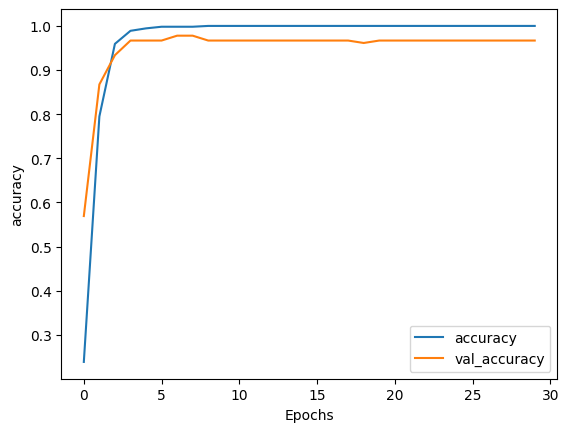

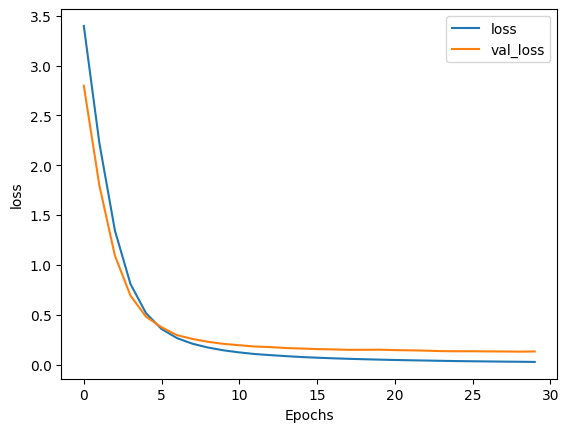

In [ ]:
# Buat fungsi untuk plotting hasil training
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(Bert_32_2e_30, 'accuracy')
plot_graphs(Bert_32_2e_30, 'loss')

In [ ]:
score = bert_model.evaluate(test_encoded_32)

print("Test Accuracy:", score[1])
print("Test Loss:", score[0])

12/12 [==============================] - 1s 61ms/step - loss: 0.1012 - accuracy: 0.9779
Test Accuracy: 0.9779005646705627
Test Loss: 0.10123705863952637


In [ ]:
bert_model.save_weights(f'/content/drive/MyDrive/SAVI File/New Model/Bert_32_2e_30.h5')

#### Epoch = 50

In [ ]:
bert_model = TFBertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL, num_labels=43)
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_2E)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
bert_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
%%time
# Compile model
Bert_32_2e_50 = bert_model.fit(train_encoded_32, epochs=EPOCHS_50, batch_size=BATCH_SIZE_32, validation_data=val_encoded_32)

Epoch 1/50
34/34 [==============================] - 54s 266ms/step - loss: 3.3596 - accuracy: 0.2865 - val_loss: 2.7047 - val_accuracy: 0.6464
Epoch 2/50
34/34 [==============================] - 4s 114ms/step - loss: 2.1369 - accuracy: 0.8595 - val_loss: 1.6600 - val_accuracy: 0.9282
Epoch 3/50
34/34 [==============================] - 5s 140ms/step - loss: 1.2727 - accuracy: 0.9760 - val_loss: 1.0094 - val_accuracy: 0.9503
Epoch 4/50
34/34 [==============================] - 4s 123ms/step - loss: 0.7684 - accuracy: 0.9908 - val_loss: 0.6528 - val_accuracy: 0.9503
Epoch 5/50
34/34 [==============================] - 4s 115ms/step - loss: 0.4966 - accuracy: 0.9926 - val_loss: 0.4596 - val_accuracy: 0.9613
Epoch 6/50
34/34 [==============================] - 4s 118ms/step - loss: 0.3450 - accuracy: 1.0000 - val_loss: 0.3494 - val_accuracy: 0.9779
Epoch 7/50
34/34 [==============================] - 5s 146ms/step - loss: 0.2580 - accuracy: 1.0000 - val_loss: 0.2871 - val_accuracy: 0.9724
Epoch

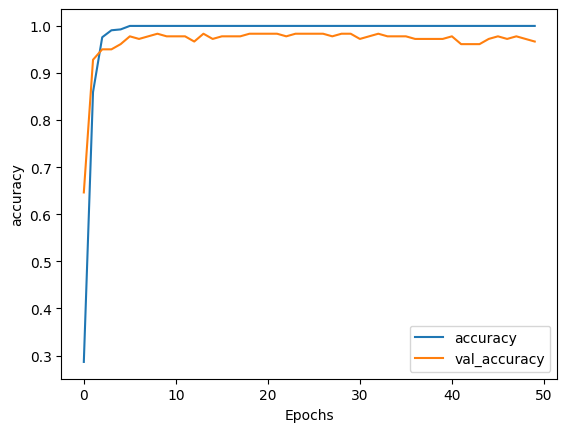

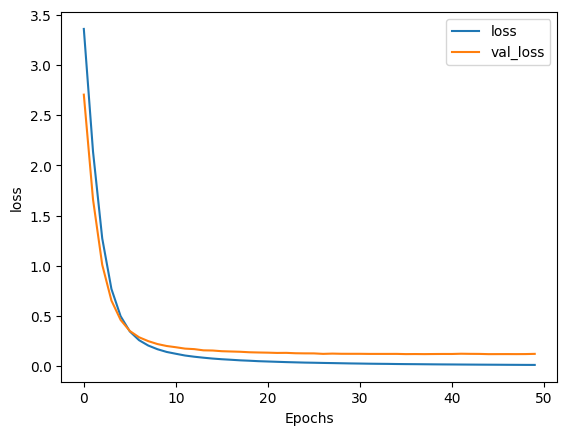

In [ ]:
# Buat fungsi untuk plotting hasil training
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(Bert_32_2e_50, 'accuracy')
plot_graphs(Bert_32_2e_50, 'loss')

In [ ]:
score = bert_model.evaluate(test_encoded_32)

print("Test Accuracy:", score[1])
print("Test Loss:", score[0])

12/12 [==============================] - 1s 47ms/step - loss: 0.0763 - accuracy: 0.9779
Test Accuracy: 0.9779005646705627
Test Loss: 0.07632383704185486


In [ ]:
bert_model.save_weights(f'/content/drive/MyDrive/SAVI File/New Model/Bert_32_2e_50.h5')

## Save model .h5

#### Berdasarkan Waktu

In [ ]:
'''import datetime

tanggal = datetime.date.today()'''

In [ ]:
'''from datetime import datetime
waktu = datetime.now()
jam = waktu.strftime("%H-%M")'''

In [ ]:
'''bert_model.save_weights(f'Model/BERTSavi98%_{tanggal}_{jam}.h5')'''

#### Berdasarkan hyperparameter

## Confusion Matriks

### BS= 16, LR=5E

#### E=10

In [ ]:
bert_load_model = TFBertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL, num_labels=43)

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_5E)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

bert_load_model.load_weights('/content/drive/MyDrive/SAVI File/New Model/Bert_16_5e_10.h5')
bert_load_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support

predicted_raw = bert_load_model.predict(test_encoded_16)
y_pred = np.argmax(predicted_raw['logits'], axis=1)
y_true = np.array(df_test['tags'])

labels = range(43)
conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)

class_report = classification_report(y_true, y_pred, labels=labels, target_names=[f'Label {l}' for l in labels], output_dict=True)
accuracy = accuracy_score(y_true, y_pred)  # Ganti 'accuracy' dengan 'accuracy_score'

# Menghitung Precision, Recall, dan F1-Score untuk setiap kelas secara terpisah
precision, recall, f1_score, support = precision_recall_fscore_support(y_true, y_pred)

# Menghitung rata-rata metrik jika diperlukan
average_precision = sum(precision) / len(precision)
average_recall = sum(recall) / len(recall)
average_f1 = sum(f1_score) / len(f1_score)
print('Average Metrics:')
print(f'  Average Precision: {average_precision:}')
print(f'  Average Recall: {average_recall:}')
print(f'  Average F1-Score: {average_f1:}')


12/12 [==============================] - 4s 45ms/step
Average Metrics:
  Average Precision: 0.988704318936877
  Average Recall: 0.9767441860465116
  Average F1-Score: 0.9772609819121448


#### E=30

In [ ]:
bert_load_model = TFBertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL, num_labels=43)

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_5E)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

bert_load_model.load_weights('/content/drive/MyDrive/SAVI File/New Model/Bert_16_5e_30.h5')
bert_load_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support

predicted_raw = bert_load_model.predict(test_encoded_16)
y_pred = np.argmax(predicted_raw['logits'], axis=1)
y_true = np.array(df_test['tags'])

labels = range(42)
conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)

class_report = classification_report(y_true, y_pred, labels=labels, target_names=[f'Label {l}' for l in labels], output_dict=True)
accuracy = accuracy_score(y_true, y_pred)  # Ganti 'accuracy' dengan 'accuracy_score'

# Menghitung Precision, Recall, dan F1-Score untuk setiap kelas secara terpisah
precision, recall, f1_score, support = precision_recall_fscore_support(y_true, y_pred)

# Menghitung rata-rata metrik jika diperlukan
average_precision = sum(precision) / len(precision)
average_recall = sum(recall) / len(recall)
average_f1 = sum(f1_score) / len(f1_score)
print('Average Metrics:')
print(f'  Average Precision: {average_precision:}')
print(f'  Average Recall: {average_recall:}')
print(f'  Average F1-Score: {average_f1:}')


12/12 [==============================] - 3s 42ms/step
Average Metrics:
  Average Precision: 0.996124031007752
  Average Recall: 0.9961240310077518
  Average F1-Score: 0.9957716701902749


#### E=50

In [ ]:
bert_load_model = TFBertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL, num_labels=43)

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_5E)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

bert_load_model.load_weights('/content/drive/MyDrive/SAVI File/New Model/Bert_16_5e_50.h5')
bert_load_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support

predicted_raw = bert_load_model.predict(test_encoded_16)
y_pred = np.argmax(predicted_raw['logits'], axis=1)
y_true = np.array(df_test['tags'])

labels = range(42)
conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)

class_report = classification_report(y_true, y_pred, labels=labels, target_names=[f'Label {l}' for l in labels], output_dict=True)
accuracy = accuracy_score(y_true, y_pred)  # Ganti 'accuracy' dengan 'accuracy_score'

# Menghitung Precision, Recall, dan F1-Score untuk setiap kelas secara terpisah
precision, recall, f1_score, support = precision_recall_fscore_support(y_true, y_pred)

# Menghitung rata-rata metrik jika diperlukan
average_precision = sum(precision) / len(precision)
average_recall = sum(recall) / len(recall)
average_f1 = sum(f1_score) / len(f1_score)
print('Average Metrics:')
print(f'  Average Precision: {average_precision:}')
print(f'  Average Recall: {average_recall:}')
print(f'  Average F1-Score: {average_f1:}')


12/12 [==============================] - 4s 43ms/step
Average Metrics:
  Average Precision: 0.983720930232558
  Average Recall: 0.9713178294573643
  Average F1-Score: 0.9725997516695192


### BS= 16, LR=3E

#### E=10

In [ ]:
bert_load_model = TFBertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL, num_labels=43)

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_3E)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

bert_load_model.load_weights('/content/drive/MyDrive/SAVI File/New Model/Bert_16_3e_10.h5')
bert_load_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support

predicted_raw = bert_load_model.predict(test_encoded_16)
y_pred = np.argmax(predicted_raw['logits'], axis=1)
y_true = np.array(df_test['tags'])

labels = range(42)
conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)

class_report = classification_report(y_true, y_pred, labels=labels, target_names=[f'Label {l}' for l in labels], output_dict=True)
accuracy = accuracy_score(y_true, y_pred)  # Ganti 'accuracy' dengan 'accuracy_score'

# Menghitung Precision, Recall, dan F1-Score untuk setiap kelas secara terpisah
precision, recall, f1_score, support = precision_recall_fscore_support(y_true, y_pred)

# Menghitung rata-rata metrik jika diperlukan
average_precision = sum(precision) / len(precision)
average_recall = sum(recall) / len(recall)
average_f1 = sum(f1_score) / len(f1_score)
print('Average Metrics:')
print(f'  Average Precision: {average_precision:}')
print(f'  Average Recall: {average_recall:}')
print(f'  Average F1-Score: {average_f1:}')


12/12 [==============================] - 4s 42ms/step
Average Metrics:
  Average Precision: 0.983720930232558
  Average Recall: 0.9713178294573643
  Average F1-Score: 0.9725997516695192


#### E=30

In [ ]:
bert_load_model = TFBertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL, num_labels=43)

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_3E)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

bert_load_model.load_weights('/content/drive/MyDrive/SAVI File/New Model/Bert_16_3e_30.h5')
bert_load_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support

predicted_raw = bert_load_model.predict(test_encoded_16)
y_pred = np.argmax(predicted_raw['logits'], axis=1)
y_true = np.array(df_test['tags'])

labels = range(42)
conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)

class_report = classification_report(y_true, y_pred, labels=labels, target_names=[f'Label {l}' for l in labels], output_dict=True)
accuracy = accuracy_score(y_true, y_pred)  # Ganti 'accuracy' dengan 'accuracy_score'

# Menghitung Precision, Recall, dan F1-Score untuk setiap kelas secara terpisah
precision, recall, f1_score, support = precision_recall_fscore_support(y_true, y_pred)

# Menghitung rata-rata metrik jika diperlukan
average_precision = sum(precision) / len(precision)
average_recall = sum(recall) / len(recall)
average_f1 = sum(f1_score) / len(f1_score)
print('Average Metrics:')
print(f'  Average Precision: {average_precision:}')
print(f'  Average Recall: {average_recall:}')
print(f'  Average F1-Score: {average_f1:}')


12/12 [==============================] - 5s 58ms/step
Average Metrics:
  Average Precision: 0.9914728682170543
  Average Recall: 0.9806201550387598
  Average F1-Score: 0.9815597838853655


#### E=50

In [ ]:
bert_load_model = TFBertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL, num_labels=43)

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_3E)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

bert_load_model.load_weights('/content/drive/MyDrive/SAVI File/New Model/Bert_16_3e_50.h5')
bert_load_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support

predicted_raw = bert_load_model.predict(test_encoded_16)
y_pred = np.argmax(predicted_raw['logits'], axis=1)
y_true = np.array(df_test['tags'])

labels = range(42)
conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)

class_report = classification_report(y_true, y_pred, labels=labels, target_names=[f'Label {l}' for l in labels], output_dict=True)
accuracy = accuracy_score(y_true, y_pred)  # Ganti 'accuracy' dengan 'accuracy_score'

# Menghitung Precision, Recall, dan F1-Score untuk setiap kelas secara terpisah
precision, recall, f1_score, support = precision_recall_fscore_support(y_true, y_pred)

# Menghitung rata-rata metrik jika diperlukan
average_precision = sum(precision) / len(precision)
average_recall = sum(recall) / len(recall)
average_f1 = sum(f1_score) / len(f1_score)
print('Average Metrics:')
print(f'  Average Precision: {average_precision:}')
print(f'  Average Recall: {average_recall:}')
print(f'  Average F1-Score: {average_f1:}')


12/12 [==============================] - 5s 58ms/step
Average Metrics:
  Average Precision: 0.983720930232558
  Average Recall: 0.9713178294573643
  Average F1-Score: 0.9725997516695192


### BS= 16, LR=2E

#### E=10

In [ ]:
bert_load_model = TFBertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL, num_labels=43)

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_2E)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

bert_load_model.load_weights('/content/drive/MyDrive/SAVI File/New Model/Bert_16_2e_10.h5')
bert_load_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support

predicted_raw = bert_load_model.predict(test_encoded_16)
y_pred = np.argmax(predicted_raw['logits'], axis=1)
y_true = np.array(df_test['tags'])

labels = range(42)
conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)

class_report = classification_report(y_true, y_pred, labels=labels, target_names=[f'Label {l}' for l in labels], output_dict=True)
accuracy = accuracy_score(y_true, y_pred)  # Ganti 'accuracy' dengan 'accuracy_score'

# Menghitung Precision, Recall, dan F1-Score untuk setiap kelas secara terpisah
precision, recall, f1_score, support = precision_recall_fscore_support(y_true, y_pred)

# Menghitung rata-rata metrik jika diperlukan
average_precision = sum(precision) / len(precision)
average_recall = sum(recall) / len(recall)
average_f1 = sum(f1_score) / len(f1_score)
print('Average Metrics:')
print(f'  Average Precision: {average_precision:}')
print(f'  Average Recall: {average_recall:}')
print(f'  Average F1-Score: {average_f1:}')


12/12 [==============================] - 5s 60ms/step
Average Metrics:
  Average Precision: 0.9914728682170543
  Average Recall: 0.9806201550387598
  Average F1-Score: 0.9815597838853655


#### E=30

In [ ]:
bert_load_model = TFBertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL, num_labels=43)

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_2E)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

bert_load_model.load_weights('/content/drive/MyDrive/SAVI File/New Model/Bert_16_2e_30.h5')
bert_load_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support

predicted_raw = bert_load_model.predict(test_encoded_16)
y_pred = np.argmax(predicted_raw['logits'], axis=1)
y_true = np.array(df_test['tags'])

labels = range(42)
conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)

class_report = classification_report(y_true, y_pred, labels=labels, target_names=[f'Label {l}' for l in labels], output_dict=True)
accuracy = accuracy_score(y_true, y_pred)  # Ganti 'accuracy' dengan 'accuracy_score'

# Menghitung Precision, Recall, dan F1-Score untuk setiap kelas secara terpisah
precision, recall, f1_score, support = precision_recall_fscore_support(y_true, y_pred)

# Menghitung rata-rata metrik jika diperlukan
average_precision = sum(precision) / len(precision)
average_recall = sum(recall) / len(recall)
average_f1 = sum(f1_score) / len(f1_score)
print('Average Metrics:')
print(f'  Average Precision: {average_precision:}')
print(f'  Average Recall: {average_recall:}')
print(f'  Average F1-Score: {average_f1:}')


12/12 [==============================] - 4s 44ms/step
Average Metrics:
  Average Precision: 0.9798449612403101
  Average Recall: 0.9655038759689922
  Average F1-Score: 0.967163327628444


#### E=50

In [ ]:
bert_load_model = TFBertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL, num_labels=43)

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_2E)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

bert_load_model.load_weights('/content/drive/MyDrive/SAVI File/New Model/Bert_16_2e_50.h5')
bert_load_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support

predicted_raw = bert_load_model.predict(test_encoded_16)
y_pred = np.argmax(predicted_raw['logits'], axis=1)
y_true = np.array(df_test['tags'])

labels = range(42)
conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)

class_report = classification_report(y_true, y_pred, labels=labels, target_names=[f'Label {l}' for l in labels], output_dict=True)
accuracy = accuracy_score(y_true, y_pred)  # Ganti 'accuracy' dengan 'accuracy_score'

# Menghitung Precision, Recall, dan F1-Score untuk setiap kelas secara terpisah
precision, recall, f1_score, support = precision_recall_fscore_support(y_true, y_pred)

# Menghitung rata-rata metrik jika diperlukan
average_precision = sum(precision) / len(precision)
average_recall = sum(recall) / len(recall)
average_f1 = sum(f1_score) / len(f1_score)
print('Average Metrics:')
print(f'  Average Precision: {average_precision:}')
print(f'  Average Recall: {average_recall:}')
print(f'  Average F1-Score: {average_f1:}')


12/12 [==============================] - 4s 41ms/step
Average Metrics:
  Average Precision: 0.9885658914728682
  Average Recall: 0.9748062015503877
  Average F1-Score: 0.9766871371522533


### BS= 32, LR=5E

#### E=10

In [ ]:
bert_load_model = TFBertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL, num_labels=43)

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_5E)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

bert_load_model.load_weights('/content/drive/MyDrive/SAVI File/New Model/Bert_32_5e_10.h5')
bert_load_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support

predicted_raw = bert_load_model.predict(test_encoded_32)
y_pred = np.argmax(predicted_raw['logits'], axis=1)
y_true = np.array(df_test['tags'])

labels = range(42)
conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)

class_report = classification_report(y_true, y_pred, labels=labels, target_names=[f'Label {l}' for l in labels], output_dict=True)
accuracy = accuracy_score(y_true, y_pred)  # Ganti 'accuracy' dengan 'accuracy_score'

# Menghitung Precision, Recall, dan F1-Score untuk setiap kelas secara terpisah
precision, recall, f1_score, support = precision_recall_fscore_support(y_true, y_pred)

# Menghitung rata-rata metrik jika diperlukan
average_precision = sum(precision) / len(precision)
average_recall = sum(recall) / len(recall)
average_f1 = sum(f1_score) / len(f1_score)
print('Average Metrics:')
print(f'  Average Precision: {average_precision:}')
print(f'  Average Recall: {average_recall:}')
print(f'  Average F1-Score: {average_f1:}')


12/12 [==============================] - 7s 57ms/step
Average Metrics:
  Average Precision: 0.9914728682170543
  Average Recall: 0.9806201550387598
  Average F1-Score: 0.9815597838853655


#### E=30

In [ ]:
bert_load_model = TFBertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL, num_labels=43)

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_5E)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

bert_load_model.load_weights('/content/drive/MyDrive/SAVI File/New Model/Bert_32_5e_30.h5')
bert_load_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support

predicted_raw = bert_load_model.predict(test_encoded_32)
y_pred = np.argmax(predicted_raw['logits'], axis=1)
y_true = np.array(df_test['tags'])

labels = range(42)
conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)

class_report = classification_report(y_true, y_pred, labels=labels, target_names=[f'Label {l}' for l in labels], output_dict=True)
accuracy = accuracy_score(y_true, y_pred)  # Ganti 'accuracy' dengan 'accuracy_score'

# Menghitung Precision, Recall, dan F1-Score untuk setiap kelas secara terpisah
precision, recall, f1_score, support = precision_recall_fscore_support(y_true, y_pred)

# Menghitung rata-rata metrik jika diperlukan
average_precision = sum(precision) / len(precision)
average_recall = sum(recall) / len(recall)
average_f1 = sum(f1_score) / len(f1_score)
print('Average Metrics:')
print(f'  Average Precision: {average_precision:}')
print(f'  Average Recall: {average_recall:}')
print(f'  Average F1-Score: {average_f1:}')


12/12 [==============================] - 5s 58ms/step
Average Metrics:
  Average Precision: 0.9914728682170543
  Average Recall: 0.9806201550387598
  Average F1-Score: 0.9815597838853655


#### E=50

In [ ]:
bert_load_model = TFBertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL, num_labels=43)

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_5E)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

bert_load_model.load_weights('/content/drive/MyDrive/SAVI File/New Model/Bert_32_5e_50.h5')
bert_load_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support

predicted_raw = bert_load_model.predict(test_encoded_32)
y_pred = np.argmax(predicted_raw['logits'], axis=1)
y_true = np.array(df_test['tags'])

labels = range(42)
conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)

class_report = classification_report(y_true, y_pred, labels=labels, target_names=[f'Label {l}' for l in labels], output_dict=True)
accuracy = accuracy_score(y_true, y_pred)  # Ganti 'accuracy' dengan 'accuracy_score'

# Menghitung Precision, Recall, dan F1-Score untuk setiap kelas secara terpisah
precision, recall, f1_score, support = precision_recall_fscore_support(y_true, y_pred)

# Menghitung rata-rata metrik jika diperlukan
average_precision = sum(precision) / len(precision)
average_recall = sum(recall) / len(recall)
average_f1 = sum(f1_score) / len(f1_score)
print('Average Metrics:')
print(f'  Average Precision: {average_precision:}')
print(f'  Average Recall: {average_recall:}')
print(f'  Average F1-Score: {average_f1:}')


12/12 [==============================] - 4s 54ms/step
Average Metrics:
  Average Precision: 0.9953488372093022
  Average Recall: 0.9844961240310078
  Average F1-Score: 0.9857881136950903


### BS= 32, LR=3E

#### E=10

In [ ]:
bert_load_model = TFBertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL, num_labels=43)

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_3E)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

bert_load_model.load_weights('/content/drive/MyDrive/SAVI File/New Model/Bert_32_3e_10.h5')
bert_load_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support

predicted_raw = bert_load_model.predict(test_encoded_32)
y_pred = np.argmax(predicted_raw['logits'], axis=1)
y_true = np.array(df_test['tags'])

labels = range(42)
conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)

class_report = classification_report(y_true, y_pred, labels=labels, target_names=[f'Label {l}' for l in labels], output_dict=True)
accuracy = accuracy_score(y_true, y_pred)  # Ganti 'accuracy' dengan 'accuracy_score'

# Menghitung Precision, Recall, dan F1-Score untuk setiap kelas secara terpisah
precision, recall, f1_score, support = precision_recall_fscore_support(y_true, y_pred)

# Menghitung rata-rata metrik jika diperlukan
average_precision = sum(precision) / len(precision)
average_recall = sum(recall) / len(recall)
average_f1 = sum(f1_score) / len(f1_score)
print('Average Metrics:')
print(f'  Average Precision: {average_precision:}')
print(f'  Average Recall: {average_recall:}')
print(f'  Average F1-Score: {average_f1:}')


12/12 [==============================] - 3s 45ms/step
Average Metrics:
  Average Precision: 0.9868217054263567
  Average Recall: 0.9767441860465116
  Average F1-Score: 0.9764388066713648


#### E=30

In [ ]:
bert_load_model = TFBertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL, num_labels=43)

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_3E)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

bert_load_model.load_weights('/content/drive/MyDrive/SAVI File/New Model/Bert_32_3e_30.h5')
bert_load_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support

predicted_raw = bert_load_model.predict(test_encoded_32)
y_pred = np.argmax(predicted_raw['logits'], axis=1)
y_true = np.array(df_test['tags'])

labels = range(42)
conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)

class_report = classification_report(y_true, y_pred, labels=labels, target_names=[f'Label {l}' for l in labels], output_dict=True)
accuracy = accuracy_score(y_true, y_pred)  # Ganti 'accuracy' dengan 'accuracy_score'

# Menghitung Precision, Recall, dan F1-Score untuk setiap kelas secara terpisah
precision, recall, f1_score, support = precision_recall_fscore_support(y_true, y_pred)

# Menghitung rata-rata metrik jika diperlukan
average_precision = sum(precision) / len(precision)
average_recall = sum(recall) / len(recall)
average_f1 = sum(f1_score) / len(f1_score)
print('Average Metrics:')
print(f'  Average Precision: {average_precision:}')
print(f'  Average Recall: {average_recall:}')
print(f'  Average F1-Score: {average_f1:}')


12/12 [==============================] - 5s 65ms/step
Average Metrics:
  Average Precision: 0.983720930232558
  Average Recall: 0.9713178294573643
  Average F1-Score: 0.9725997516695192


#### E=50

In [ ]:
bert_load_model = TFBertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL, num_labels=43)

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_3E)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

bert_load_model.load_weights('/content/drive/MyDrive/SAVI File/New Model/Bert_32_3e_50.h5')
bert_load_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support

predicted_raw = bert_load_model.predict(test_encoded_32)
y_pred = np.argmax(predicted_raw['logits'], axis=1)
y_true = np.array(df_test['tags'])

labels = range(42)
conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)

class_report = classification_report(y_true, y_pred, labels=labels, target_names=[f'Label {l}' for l in labels], output_dict=True)
accuracy = accuracy_score(y_true, y_pred)  # Ganti 'accuracy' dengan 'accuracy_score'

# Menghitung Precision, Recall, dan F1-Score untuk setiap kelas secara terpisah
precision, recall, f1_score, support = precision_recall_fscore_support(y_true, y_pred)

# Menghitung rata-rata metrik jika diperlukan
average_precision = sum(precision) / len(precision)
average_recall = sum(recall) / len(recall)
average_f1 = sum(f1_score) / len(f1_score)
print('Average Metrics:')
print(f'  Average Precision: {average_precision:}')
print(f'  Average Recall: {average_recall:}')
print(f'  Average F1-Score: {average_f1:}')


12/12 [==============================] - 4s 98ms/step
Average Metrics:
  Average Precision: 0.983720930232558
  Average Recall: 0.9713178294573643
  Average F1-Score: 0.9725997516695192


### BS= 32, LR=2E

#### E=10

In [ ]:
bert_load_model = TFBertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL, num_labels=43)

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_2E)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

bert_load_model.load_weights('/content/drive/MyDrive/SAVI File/New Model/Bert_32_2e_10.h5')
bert_load_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support

predicted_raw = bert_load_model.predict(test_encoded_32)
y_pred = np.argmax(predicted_raw['logits'], axis=1)
y_true = np.array(df_test['tags'])

labels = range(42)
conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)

class_report = classification_report(y_true, y_pred, labels=labels, target_names=[f'Label {l}' for l in labels], output_dict=True)
accuracy = accuracy_score(y_true, y_pred)  # Ganti 'accuracy' dengan 'accuracy_score'

# Menghitung Precision, Recall, dan F1-Score untuk setiap kelas secara terpisah
precision, recall, f1_score, support = precision_recall_fscore_support(y_true, y_pred)

# Menghitung rata-rata metrik jika diperlukan
average_precision = sum(precision) / len(precision)
average_recall = sum(recall) / len(recall)
average_f1 = sum(f1_score) / len(f1_score)
print('Average Metrics:')
print(f'  Average Precision: {average_precision:}')
print(f'  Average Recall: {average_recall:}')
print(f'  Average F1-Score: {average_f1:}')


12/12 [==============================] - 3s 49ms/step
Average Metrics:
  Average Precision: 0.983720930232558
  Average Recall: 0.9713178294573643
  Average F1-Score: 0.9725997516695192


#### E=30

In [ ]:
bert_load_model = TFBertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL, num_labels=43)

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_2E)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

bert_load_model.load_weights('/content/drive/MyDrive/SAVI File/New Model/Bert_32_2e_30.h5')
bert_load_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support

predicted_raw = bert_load_model.predict(test_encoded_32)
y_pred = np.argmax(predicted_raw['logits'], axis=1)
y_true = np.array(df_test['tags'])

labels = range(42)
conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)

class_report = classification_report(y_true, y_pred, labels=labels, target_names=[f'Label {l}' for l in labels], output_dict=True)
accuracy = accuracy_score(y_true, y_pred)  # Ganti 'accuracy' dengan 'accuracy_score'

# Menghitung Precision, Recall, dan F1-Score untuk setiap kelas secara terpisah
precision, recall, f1_score, support = precision_recall_fscore_support(y_true, y_pred)

# Menghitung rata-rata metrik jika diperlukan
average_precision = sum(precision) / len(precision)
average_recall = sum(recall) / len(recall)
average_f1 = sum(f1_score) / len(f1_score)
print('Average Metrics:')
print(f'  Average Precision: {average_precision:}')
print(f'  Average Recall: {average_recall:}')
print(f'  Average F1-Score: {average_f1:}')


12/12 [==============================] - 4s 44ms/step
Average Metrics:
  Average Precision: 0.9875968992248062
  Average Recall: 0.9748062015503877
  Average F1-Score: 0.9761233598442901


#### E=50

In [ ]:
bert_load_model = TFBertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL, num_labels=43)

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_2E)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

bert_load_model.load_weights('/content/drive/MyDrive/SAVI File/New Model/Bert_32_2e_50.h5')
bert_load_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support

predicted_raw = bert_load_model.predict(test_encoded_32)
y_pred = np.argmax(predicted_raw['logits'], axis=1)
y_true = np.array(df_test['tags'])

labels = range(42)
conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)

class_report = classification_report(y_true, y_pred, labels=labels, target_names=[f'Label {l}' for l in labels], output_dict=True)
accuracy = accuracy_score(y_true, y_pred)  # Ganti 'accuracy' dengan 'accuracy_score'

# Menghitung Precision, Recall, dan F1-Score untuk setiap kelas secara terpisah
precision, recall, f1_score, support = precision_recall_fscore_support(y_true, y_pred)

# Menghitung rata-rata metrik jika diperlukan
average_precision = sum(precision) / len(precision)
average_recall = sum(recall) / len(recall)
average_f1 = sum(f1_score) / len(f1_score)
print('Average Metrics:')
print(f'  Average Precision: {average_precision:}')
print(f'  Average Recall: {average_recall:}')
print(f'  Average F1-Score: {average_f1:}')


12/12 [==============================] - 5s 61ms/step
Average Metrics:
  Average Precision: 0.9895348837209301
  Average Recall: 0.9751937984496125
  Average F1-Score: 0.9766519010705057


### Visual Confusion Matriks

In [ ]:
bert_load_model = TFBertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL, num_labels=43)

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_5E)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

bert_load_model.load_weights('/content/drive/MyDrive/SAVI File/New Model/Bert_16_5e_30.h5')
bert_load_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support

predicted_raw = bert_load_model.predict(test_encoded_16)
y_pred = np.argmax(predicted_raw['logits'], axis=1)
y_true = np.array(df_test['tags'])

labels = range(43)
conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)

class_report = classification_report(y_true, y_pred, labels=labels, target_names=[f'Label {l}' for l in labels], output_dict=True)
accuracy = accuracy_score(y_true, y_pred)  # Ganti 'accuracy' dengan 'accuracy_score'

# Menghitung Precision, Recall, dan F1-Score untuk setiap kelas secara terpisah
precision, recall, f1_score, support = precision_recall_fscore_support(y_true, y_pred)

# Menghitung rata-rata metrik jika diperlukan
average_precision = sum(precision) / len(precision)
average_recall = sum(recall) / len(recall)
average_f1 = sum(f1_score) / len(f1_score)
print('Average Metrics:')
print(f'  Average Precision: {average_precision:}')
print(f'  Average Recall: {average_recall:}')
print(f'  Average F1-Score: {average_f1:}')

In [ ]:
from sklearn.metrics import confusion_matrix
predicted_raw = bert_load_model.predict(test_encoded_16)
y_pred = np.argmax(predicted_raw['logits'], axis=1)
y_true = np.array(df_test['tags'])

labels = range(43)
conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)

class_report = classification_report(y_true, y_pred, labels=labels, target_names=[f'Label {l}' for l in labels], output_dict=True)
accuracy = accuracy_score(y_true, y_pred)  # Ganti 'accuracy' dengan 'accuracy_score'

12/12 [==============================] - 26s 61ms/step


In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support


# Hitung Precision, Recall, dan F1-Score
# Menghitung Precision, Recall, dan F1-Score untuk setiap kelas secara terpisah
precision, recall, f1_score, support = precision_recall_fscore_support(y_true, y_pred)

class_labels = sorted(list(set(classes)))

# Hasilnya akan berupa array untuk masing-masing kelas
for class_label, prec, rec, f1, supp in zip(class_labels, precision, recall, f1_score, support):
    print(f'Class {class_label}:')
    print(f'  Precision: {prec:.2f}')
    print(f'  Recall: {rec:.2f}')
    print(f'  F1-Score: {f1:.2f}')
    print(f'  Support: {supp}')
    print('-----------------')

# Menghitung rata-rata metrik jika diperlukan
average_precision = sum(precision) / len(precision)
average_recall = sum(recall) / len(recall)
average_f1 = sum(f1_score) / len(f1_score)
print('Average Metrics:')
print(f'  Average Precision: {average_precision:}')
print(f'  Average Recall: {average_recall:}')
print(f'  Average F1-Score: {average_f1:}')


Class Asal:
  Precision: 0.83
  Recall: 1.00
  F1-Score: 0.91
  Support: 5
-----------------
Class Bantu:
  Precision: 1.00
  Recall: 1.00
  F1-Score: 1.00
  Support: 2
-----------------
Class Baterai:
  Precision: 1.00
  Recall: 1.00
  F1-Score: 1.00
  Support: 4
-----------------
Class Beban:
  Precision: 1.00
  Recall: 1.00
  F1-Score: 1.00
  Support: 8
-----------------
Class Benar:
  Precision: 1.00
  Recall: 1.00
  F1-Score: 1.00
  Support: 4
-----------------
Class Berpisah:
  Precision: 1.00
  Recall: 1.00
  F1-Score: 1.00
  Support: 4
-----------------
Class Buruk:
  Precision: 1.00
  Recall: 1.00
  F1-Score: 1.00
  Support: 5
-----------------
Class Hari:
  Precision: 1.00
  Recall: 1.00
  F1-Score: 1.00
  Support: 3
-----------------
Class Hidup:
  Precision: 1.00
  Recall: 1.00
  F1-Score: 1.00
  Support: 1
-----------------
Class Hobby:
  Precision: 1.00
  Recall: 1.00
  F1-Score: 1.00
  Support: 5
-----------------
Class Hump:
  Precision: 1.00
  Recall: 1.00
  F1-Score: 

In [ ]:
from sklearn.metrics import classification_report

# Hitung metrik evaluasi
report = classification_report(y_true, y_pred, target_names = class_labels)
print(report)

              precision    recall  f1-score   support

        Asal       0.83      1.00      0.91         5
       Bantu       1.00      1.00      1.00         2
     Baterai       1.00      1.00      1.00         4
       Beban       1.00      1.00      1.00         8
       Benar       1.00      1.00      1.00         4
    Berpisah       1.00      1.00      1.00         4
       Buruk       1.00      1.00      1.00         5
        Hari       1.00      1.00      1.00         3
       Hidup       1.00      1.00      1.00         1
       Hobby       1.00      1.00      1.00         5
        Hump       1.00      1.00      1.00         4
   Identitas       1.00      1.00      1.00         4
   InfoBerat       1.00      1.00      1.00         3
   Infospeed       1.00      1.00      1.00         6
         Jam       1.00      1.00      1.00         6
       Kanan       1.00      1.00      1.00         2
        Kiri       1.00      1.00      1.00         5
   Lebihbaik       1.00    

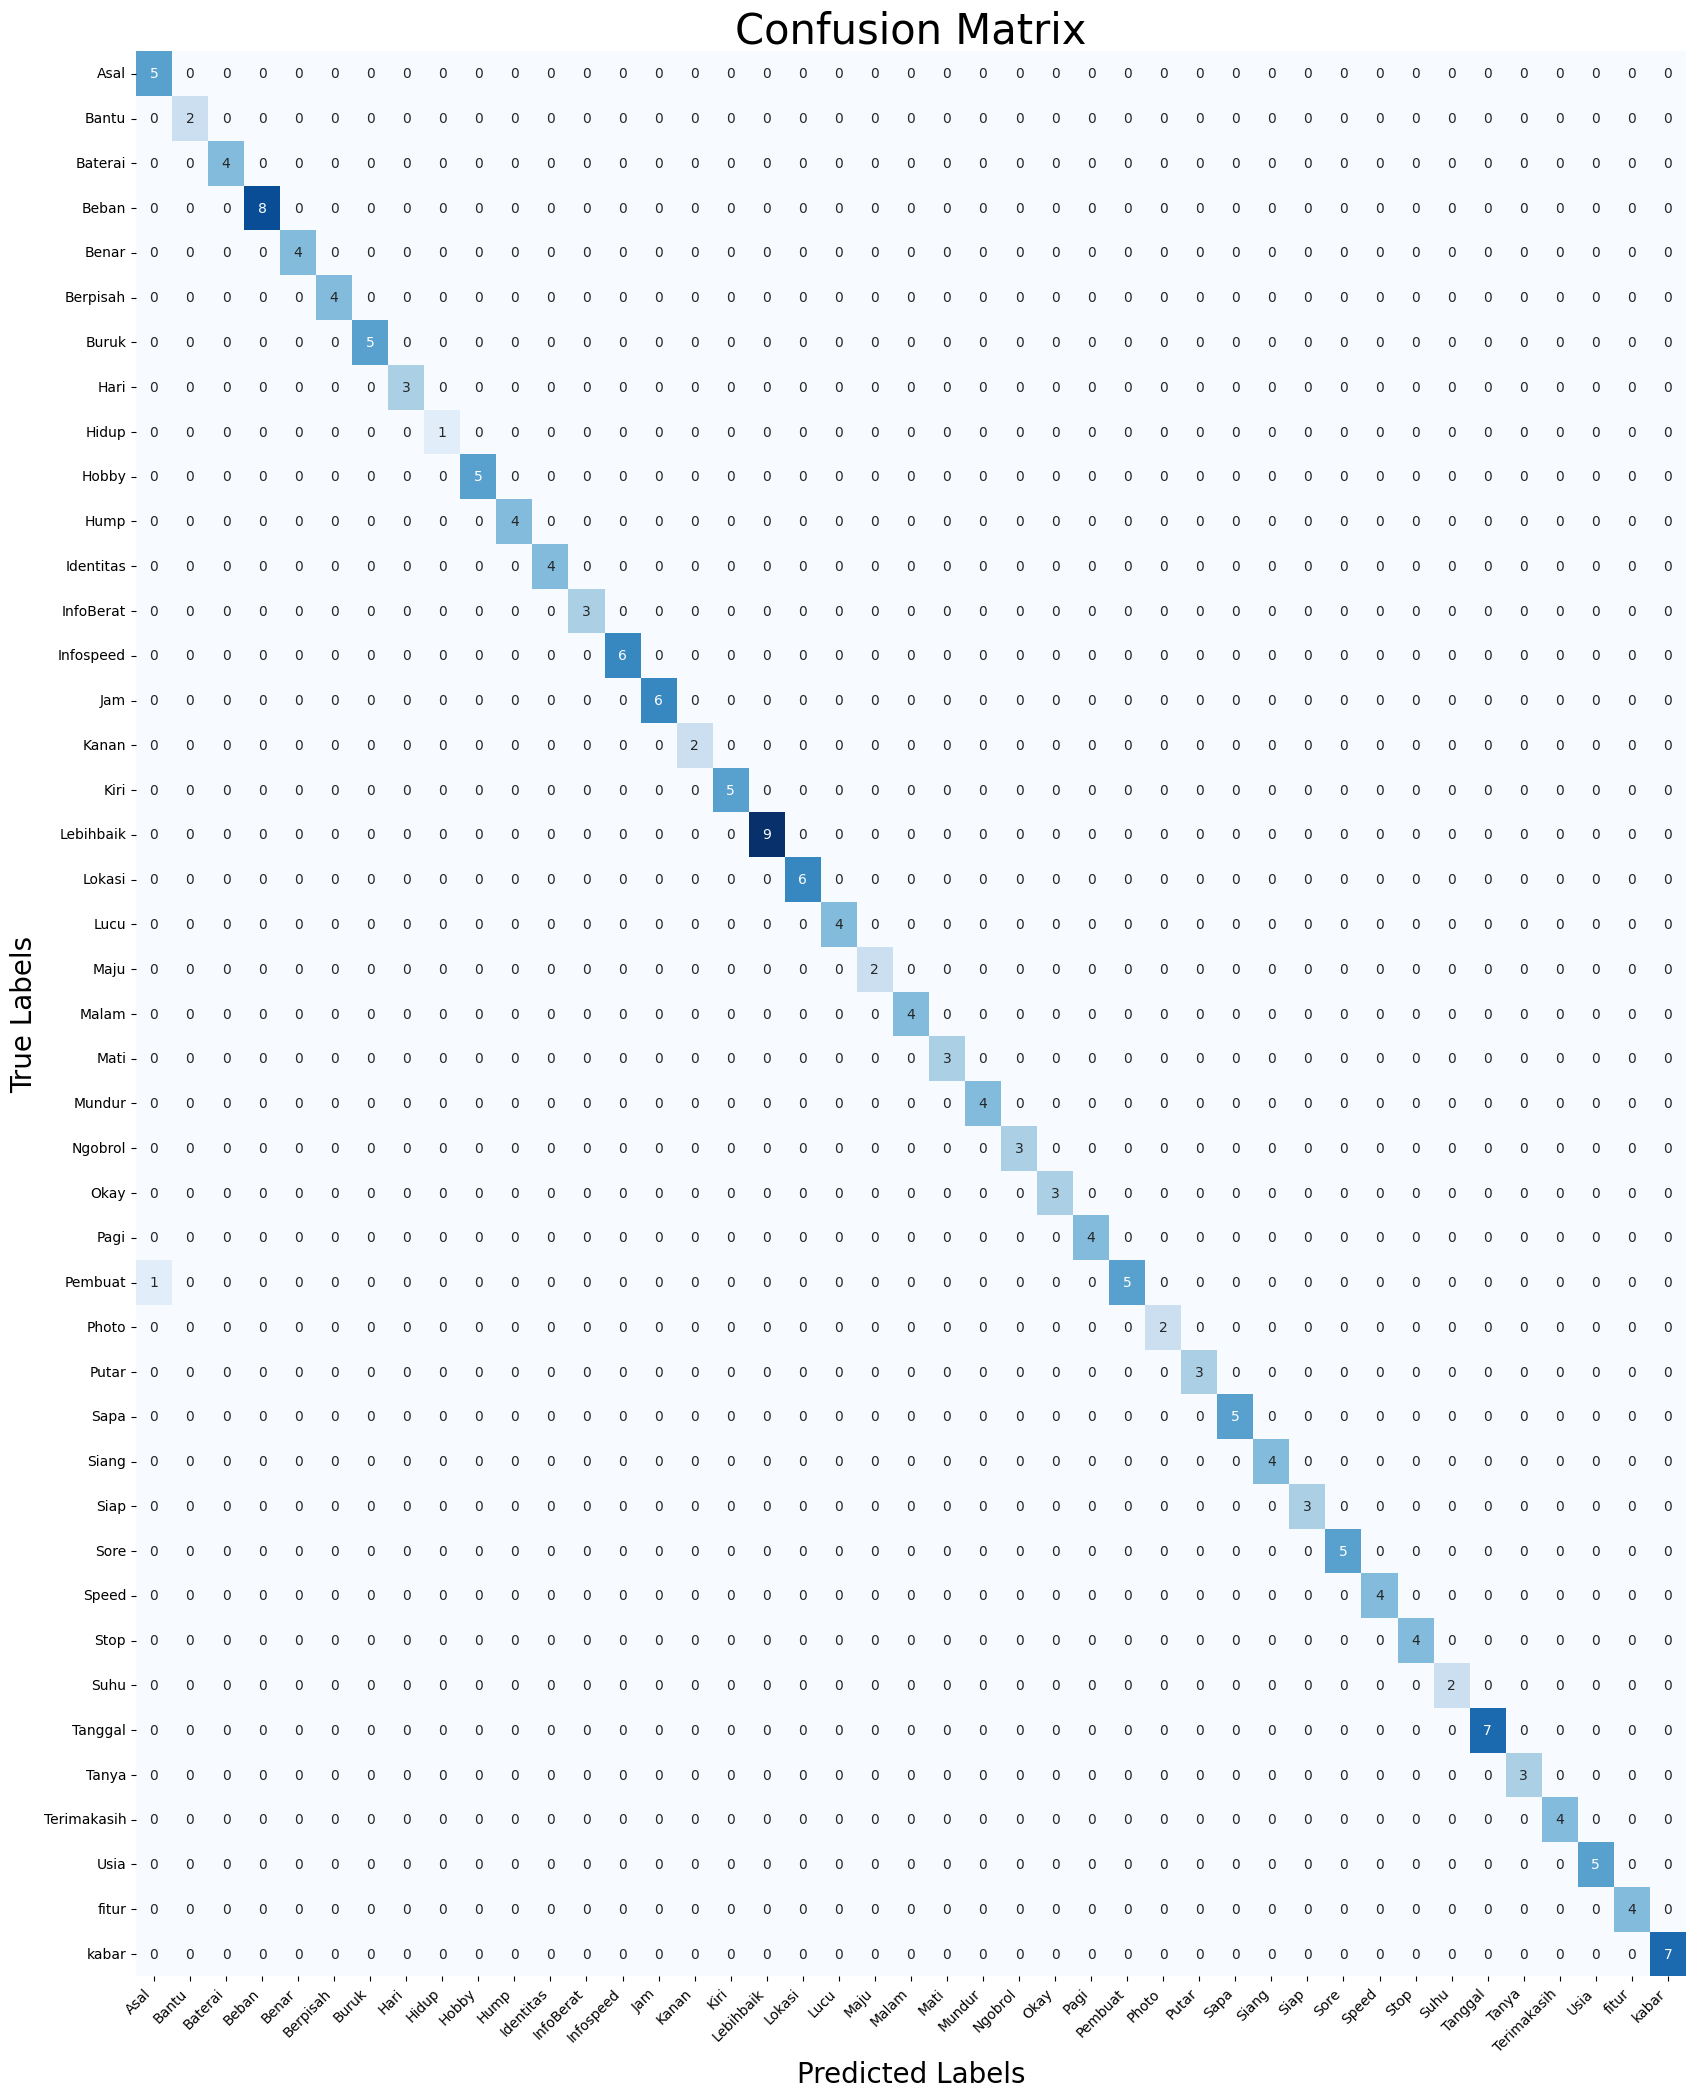

In [ ]:
plt.figure(figsize=(20,25))

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels, cbar=False)
plt.xlabel('Predicted Labels', fontsize=20)
plt.ylabel('True Labels', fontsize=20)
plt.title('Confusion Matrix', fontsize=30)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
# Tampilkan nilai akurasi, precision, recall, dan F1-score
#plt.text(2.5, -0.5, f"Accuracy: {accuracy:.2f}", fontsize=12, ha='center')
'''for idx, label in enumerate(labels):
    label_str = f'Label {label}'
    metrics_text = f"{label_str}\nPrecision {class_report[label_str]['precision']:.2f}\nRecall {class_report[label_str]['recall']:.2f}\nF1-Score {class_report[label_str]['f1-score']:.2f}"
    plt.text(len(labels) + 0.5, idx + 0.5, metrics_text, fontsize=12, va='center')'''
plt.show()

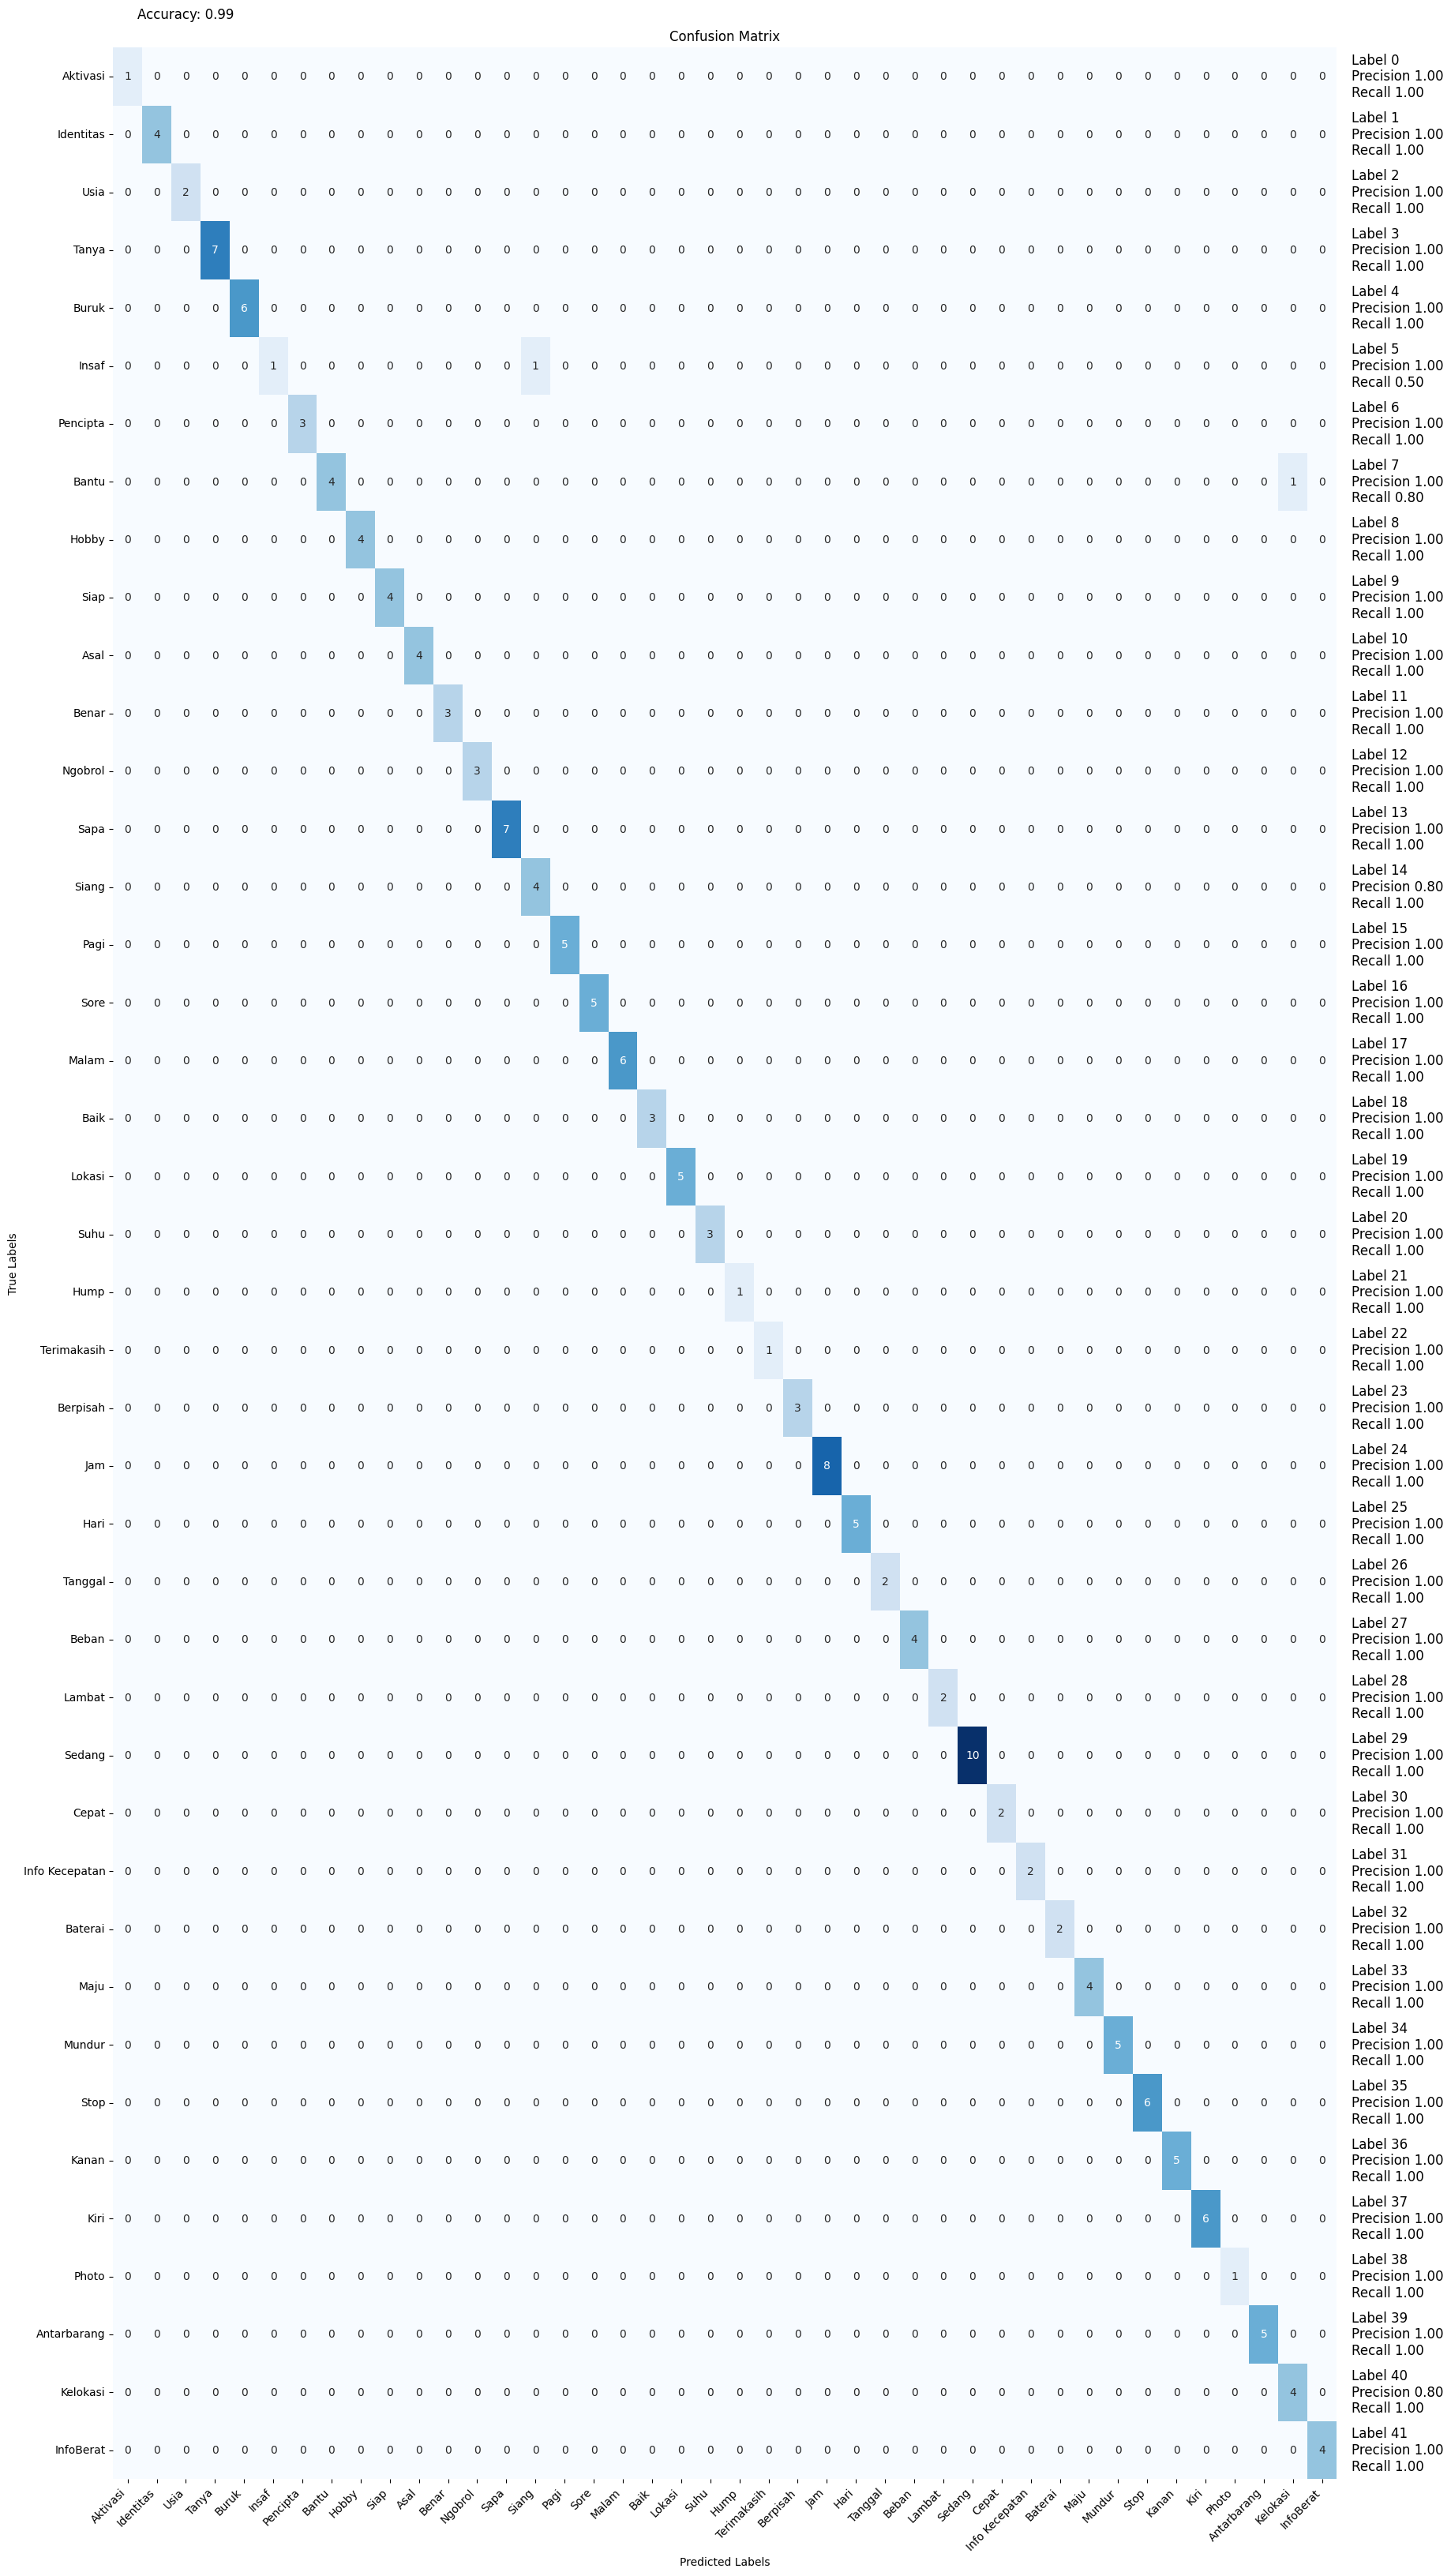

In [ ]:
plt.figure(figsize=(20,40))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes, cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
# Tampilkan nilai akurasi, precision, dan recall
plt.text(2.5, -0.5, f"Accuracy: {accuracy:.2f}", fontsize=12, ha='center')
for idx, label in enumerate(labels):
    label_str = f'Label {label}'
    plt.text(len(labels) + 0.5, idx + 0.5, f"{label_str}\nPrecision {class_report[label_str]['precision']:.2f}\nRecall {class_report[label_str]['recall']:.2f}", fontsize=12, va='center')
plt.show()